In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

## Loading in TESS Sector 14 Data

In [3]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
#target = '273589987'
target='9726699'
gj1243_tess = search_lightcurvefile(target,cadence='short',mission='TESS').download_all()

In [ ]:
gj1243_tess

In [4]:
tess_collection=gj1243_tess[-2:]
tess_collection

[TessLightCurveFile(TICID: 273589987), TessLightCurveFile(TICID: 273589987)]

In [5]:
gj1243_tesslc = tess_collection[0].PDCSAP_FLUX.remove_nans()

for q in range(1,len(tess_collection)):
    try:
        gj1243_tesslc = gj1243_tesslc.append(tess_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


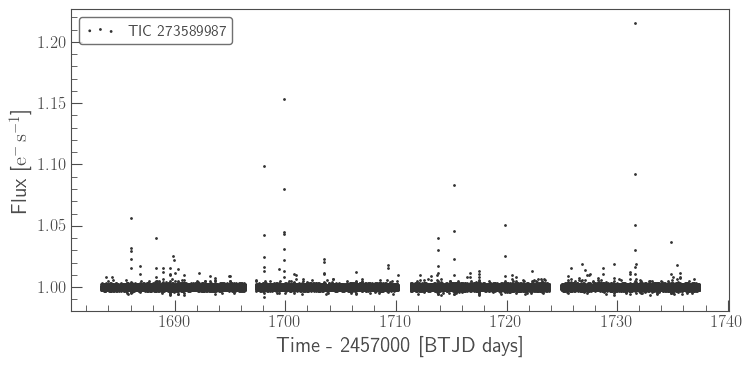

In [6]:
gj1243_tesslc.flatten(window_length=11).scatter()

In [ ]:
gj1243_tesslc.scatter()

## Loading in Flare Table (includes sector 14&15)

In [7]:
tess_flares= pd.read_csv('/Users/lupitatovar/TESS/all_tess_flares.txt',delim_whitespace=True,comment='#',names = ['Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x'])[1:]

In [8]:
t_starts = tess_flares.loc[:,'t_start'].values
t_stops = tess_flares.loc[:,'t_stop'].values
flux_peak = tess_flares.loc[:,'Flux_peak'].values

In [9]:
len(tess_flares)

132

### Running GP on TESS Data

Masking out the flares

In [10]:
#mask array for TESS lightcurve
f_mask = np.zeros_like(gj1243_tesslc.time, dtype=bool)

In [11]:

for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5  
    buffer = (gj1243_tesslc.time >= t_starts[i] - c1*dur) & (gj1243_tesslc.time <= t_stops[i] + c2*dur)
    temp = (gj1243_tesslc.time >= t_starts[i]) & (gj1243_tesslc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)
no_flare = np.where((f_mask == False))[0]
flares = np.where((f_mask == True))[0]

[False False False ... False False False]


Accounting for quarterly discontinuities

In [12]:
total_median = np.nanmedian(gj1243_tesslc.flux[no_flare])
raw_flux = 1+((gj1243_tesslc.flux - total_median)/total_median)

In [13]:
# arrays of start and stop times of each month of data
start_time = np.array([])
stop_time = np.array ([])
med_nf = np.array([])
for i in range(0,len(tess_collection)):
    try:
        month = np.where((gj1243_tesslc.time[no_flare] >= np.min(tess_collection[i].time)) & 
          (gj1243_tesslc.time[no_flare] <= np.max(tess_collection[i].time)))[0]
        start = np.min(tess_collection[i].time)
        stop = np.max(tess_collection[i].time)
        med = np.nanmedian(gj1243_tesslc.flux[no_flare][month])
        start_time = np.append(start_time,start)
        stop_time = np.append(stop_time,stop)
        med_nf = np.append(med_nf,med)
        
    except:
        print(i)

In [14]:
#Array of median fluxes across each month of data

medflux=np.array([])
for i in range(0,len(tess_collection)):
    try:
        
        month = np.where((gj1243_tesslc.time[no_flare] >= np.min(tess_collection[i].time)) & 
          (gj1243_tesslc.time[no_flare] <= np.max(tess_collection[i].time)))[0]

        med = 1+((gj1243_tesslc.flux[no_flare][month] - med_nf[i]))/total_median
        medflux = np.append(medflux,med)
    except:
            print(i)

In [15]:
flat_lc = gj1243_tesslc.flatten()

Text(0, 0.5, 'Normalized Flux')

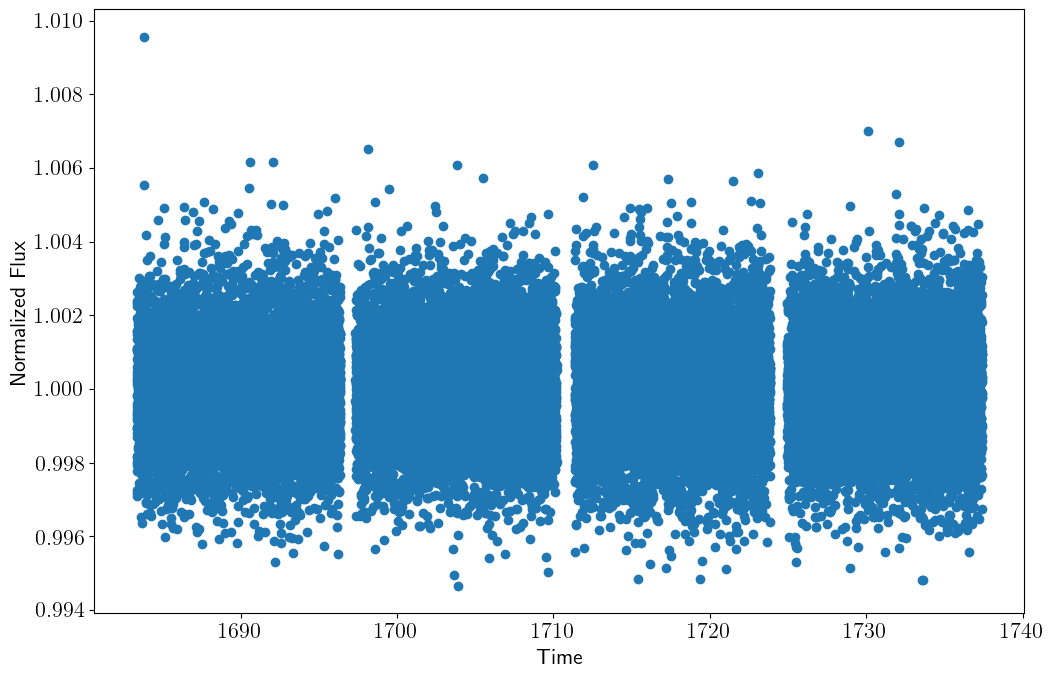

In [16]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

plt.scatter(flat_lc.time[no_flare],flat_lc.flux[no_flare]/np.nanmedian(flat_lc.flux[no_flare]))
#plt.xlim(539.4,540.4)
#plt.ylim(1.17,1.22)
#plt.xlim(1190,1200)
plt.xlabel('Time')
plt.ylabel('Normalized Flux')

### Setting up the GP

In [ ]:
for i in range (0,len(tess_collection)):
        #month is the times of each month w/o flares
        month = np.where((gj1243_tesslc.time[no_flare] >= np.min(tess_collection[i].time)) & 
                         (gj1243_tesslc.time[no_flare] <= np.max(tess_collection[i].time)))[0]
        
        
        y = medflux[month]
        t = gj1243_tesslc.time[no_flare][month]
        yerr = 1+((gj1243_tesslc.flux_err[no_flare][month] - np.nanmedian(gj1243_tesslc.flux[no_flare][month]))/(np.nanmedian(gj1243_tesslc.flux[no_flare][month])))
        yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)
        
        mok = np.where((np.abs(y-np.mean(y)) < 5*np.std(y)))
        y=y[mok]
        t=t[mok]
        yerr=yerr[mok]
        
#         if i==0:
        Q = 0.01
        w0 = 2*np.pi/0.59
        S0 = np.var(y) / (w0 * Q)
        bounds = dict(log_S0=(-15,15), log_Q=(-5,15), log_omega0=(0,15))
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)

#         print(i, np.mean(y), kernel.terms)
        
        #Running the gp
        gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
        gp.compute(t, yerr)  # You always need to call compute once.

        def neg_log_like(params, y, gp):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y)
        
#         if i==0:
        initial_params = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()
        
#         print(initial_params)
        r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
#         print(r)
        
        gp.set_parameter_vector(r.x)

        month_flares = np.where((gj1243_tesslc.time >= np.min(tess_collection[i].time)) & 
                                (gj1243_tesslc.time <= np.max(tess_collection[i].time)))[0]
        x = gj1243_tesslc.time[month_flares]

        #### HOW TO MAKE IT GO SLOW
        pred_mean, pred_var = gp.predict(y, x, return_var=True)
        #### HOW TO MAKE IT GO FAST (w/o Variance)
        #pred_mean = gp.predict(y, x, return_cov=False, return_var=False)
        #pred_var = gj1243_tesslc.flux_err[month_flares]/total_median # NOT right, just a hack for right now...

        pred_std = np.sqrt(pred_var)
        #Saving each month of the gp run
        dict_i = {'time':x,'mean': pred_mean, 'std': pred_std, 'var': pred_var, 
                'detrended_flux':(1+((gj1243_tesslc.flux[month_flares] - med_nf[i]))/total_median),
                'df_flux_err':(gj1243_tesslc.flux_err[month_flares])/total_median}  
        gp_out = pd.DataFrame(data=dict_i) 
        gp_out.to_csv(r'tess_gp_values'+str(i)+'.csv',header=True,index=True)

        #plotting to make sure each month looks reasonable
        plt.figure(figsize=(9,4))
        plt.plot(x,(1+((gj1243_tesslc.flux[month_flares] - med_nf[i]))/total_median))
        plt.plot(t,y, c='C1')
        plt.plot(x,pred_mean, c='r')
        plt.xlabel("Time")
        plt.ylabel("Flux")
        plt.title(str(i))
        
        plt.xlim(np.min(x),np.min(x) + 7)
        plt.ylim(np.mean(y)-0.025, np.mean(y)+0.05)
        plt.show()
        
        print('>>> ',sum(np.isnan(pred_mean)))

In [ ]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

In [ ]:
print(r)

In [ ]:
gp.get_parameter_dict()
print(2*np.pi /np.exp(gp.get_parameter_dict()['kernel:log_omega0']))

Importing in the gp data from .csv file

0 (18522, 7)
1 (17848, 7)


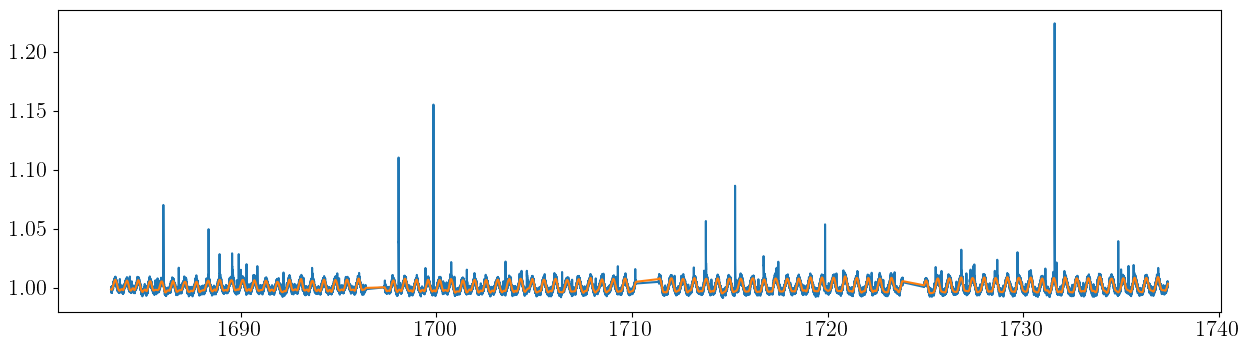

In [17]:
from glob import glob

gp_files = glob('*tess_gp*.csv')

for k in range(len(gp_files)): 
    df_tmp = pd.read_csv(gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()

Text(0.5, 0, 'Time - 2457000 [BTJD days]')

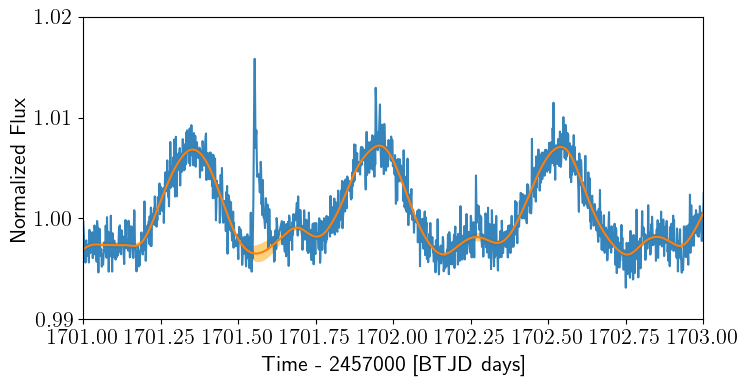

In [18]:
plt.figure(figsize=(8,4))

plt.plot(df['time'], df['detrended_flux'],alpha=0.9)
plt.plot(df['time'], df['mean'])
plt.fill_between(df['time'], df['mean']+df['std'], df['mean']-df['std'],color='orange', alpha=0.5,
                 edgecolor="none",label='gp')


plt.xlim(1701,1703)
plt.ylim(.99,1.02)
plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")

### Classical Flares

In [19]:
complex_flag = tess_flares['CPLX_flg'] #2=complex, 1 = classical
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical))

classical_flares = tess_flares[tess_flares['CPLX_flg'] == 1.0]

classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])

The number of classical flares : 47


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
classical_flares

### Stacking the Flares (using stacking procedure from 2014)

In [20]:
detrended = df['detrended_flux'].values - df['mean'].values

In [21]:
print(len(detrended))

36370


In [22]:
min(df['time'].values)

1683.3561758891572

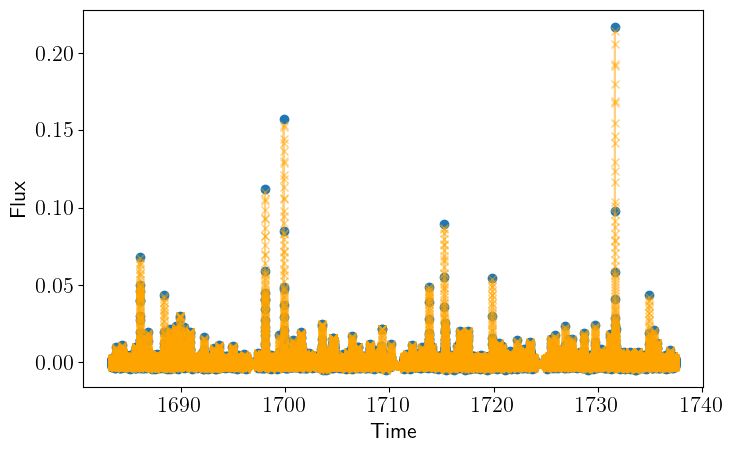

In [23]:
#interpolating the full light curve
plt.scatter(df['time'],detrended)

plt.xlabel("Time")
plt.ylabel("Flux")

padding_factor = 10
steps = padding_factor*len(detrended)

xvals = np.linspace(1683.35617589, 1737.41161827, steps)
yinterp = np.interp(xvals, df['time'], detrended)
plt.plot(xvals,yinterp,'-x',color='orange',alpha=0.5)

In [ ]:
print(len(xvals))
print(len(tess_flares['t_stop'].values))
print(len(df['time'].values))

In [ ]:
len(detrended)
len(df['time'])

In [ ]:
print(np.argmax(detrended))
print(np.argmax(detrended[t2]))

In [ ]:
(tess_flares)

Finding the flux and time values where local maxes occur w/in interpolated data (i.e where the flares happen)

In [24]:
time_max = np.array([])
peaks = np.array([])
t_halfs = np.array([])
for i in range(0,len(tess_flares)):
    #for interpolated data
    temp1 = np.where((xvals < tess_flares['t_stop'].values[i]) & 
                    (xvals > tess_flares['t_start'].values[i]))[0]
    
    #for normal data
    temp2 = np.where((df['time'].values < tess_flares['t_stop'].values[i]) & 
                    (df['time'].values > tess_flares['t_start'].values[i]))[0]

    i_max = np.argmax(detrended[temp2])
    t_max = (df['time'].values[temp2][i_max])
    flux_max = (detrended[temp2][i_max])
    time_max = np.append(time_max,t_max)
    peaks = np.append(peaks,flux_max)
    half_peaks = peaks/2.0
    i_xs = np.where((yinterp[temp1] > half_peaks[i]))[0]
    time_xs = xvals[temp1][i_xs]
    t_half = max(time_xs) - min(time_xs)
    t_halfs = np.append(t_halfs,t_half)
    flux_fwhm = np.where(yinterp > half_peaks[i])[0]
  

In [25]:
time_max2 = np.array([])
peaks2 = np.array([])
t_halfs2 = np.array([])
for i in range(0,len(classical_flares)):
    #for interpolated data
    t1 = np.where((xvals < classical_flares['t_stop'].values[i]) & 
                    (xvals > classical_flares['t_start'].values[i]))[0]
    
    #for normal data
    t2 = np.where((df['time'].values < classical_flares['t_stop'].values[i]) & 
                    (df['time'].values > classical_flares['t_start'].values[i]))[0]

    i_max2 = np.argmax(detrended[t2])
    t_max2 = (df['time'].values[t2][i_max2])
    flux_max2 = (detrended[t2][i_max2])
    time_max2 = np.append(time_max2,t_max2)
    peaks2 = np.append(peaks2,flux_max2)
    half_peaks2 = peaks2/2.0
    i_xs2 = np.where((yinterp[t1] > half_peaks2[i]))[0]
    time_xs2 = xvals[t1][i_xs2]
    t_half2 = max(time_xs2) - min(time_xs2)
    t_halfs2 = np.append(t_halfs2,t_half2)
    flux_fwhm2 = np.where(yinterp > half_peaks2[i])[0]
  

In [26]:
print(i_max)

2


Plotting the stacked flares

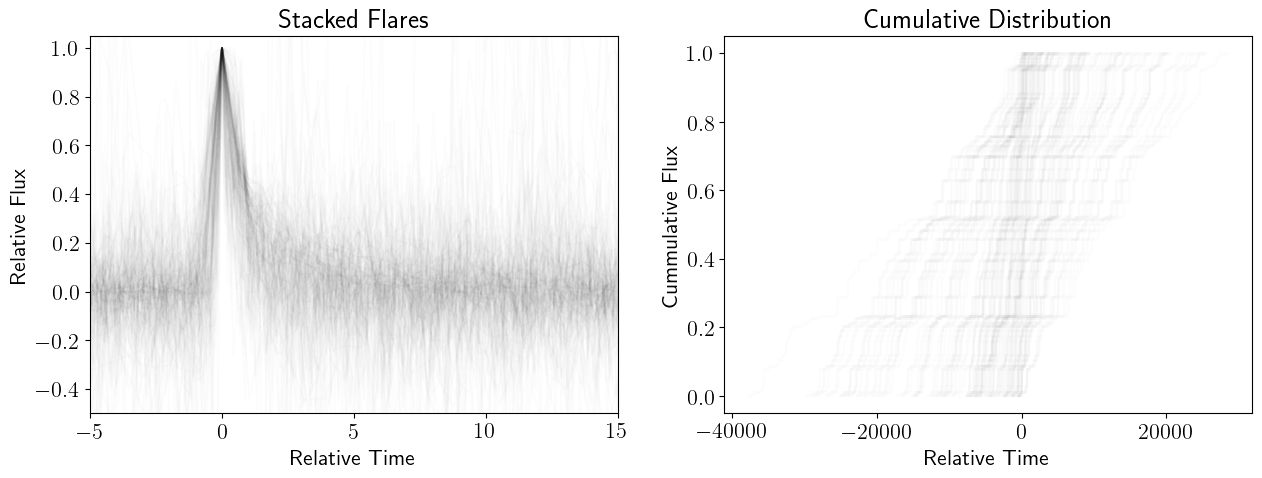

In [27]:

fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(tess_flares)):
    
    x = (df['time'] - time_max[i])/(t_halfs[i])
    y = ((detrended)/(peaks[i]))
    #plt.plot(x,y,color='b',alpha=0.01)


    axs[0].plot(x,y,color='k',alpha=0.01)

    #axs[1].plot((xinterp[2]-xinterp)/scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    #axs[1].plot((df['time'][temp])/scale_dur[i],cd_detrended,color='k',alpha=0.2)
    axs[1].plot(x,np.cumsum(y)/np.sum(y),color='k',alpha=0.01)
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-5,15)
    axs[0].set_ylim(-0.5,1.05) 

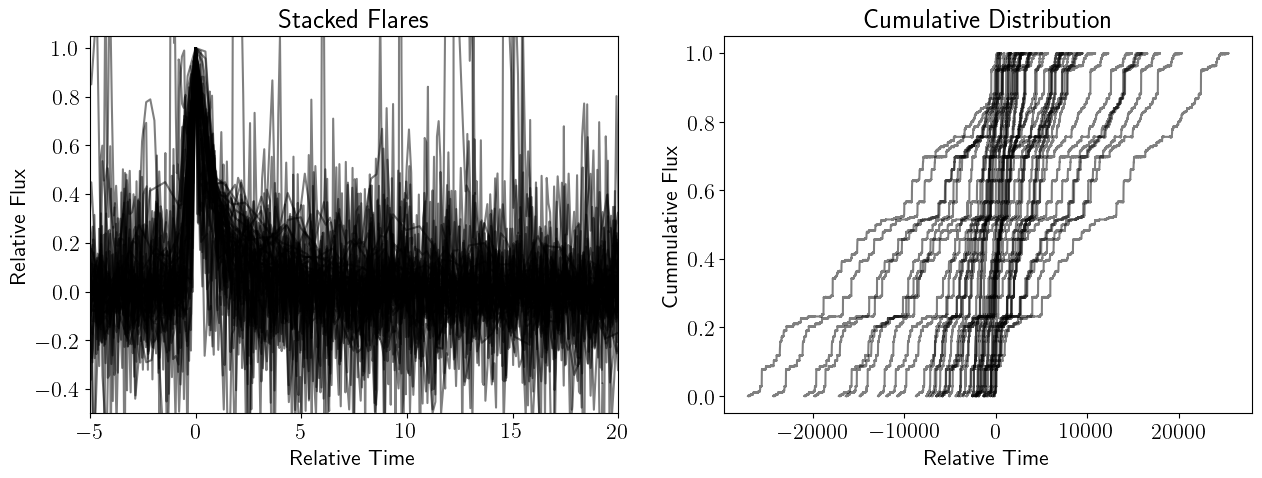

In [28]:

fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(classical_flares)):
    
    x2 = (df['time'] - time_max2[i])/(t_halfs2[i])
    y2 = ((detrended)/(peaks2[i]))
    #plt.plot(x,y,color='b',alpha=0.01)


    axs[0].plot(x2,y2,color='k',alpha=0.5)

    #axs[1].plot((xinterp[2]-xinterp)/scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    #axs[1].plot((df['time'][temp])/scale_dur[i],cd_detrended,color='k',alpha=0.2)
    axs[1].plot(x2,np.cumsum(y2)/np.sum(y2),color='k',alpha=0.5)
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-5,20)
    axs[0].set_ylim(-0.5,1.05) 

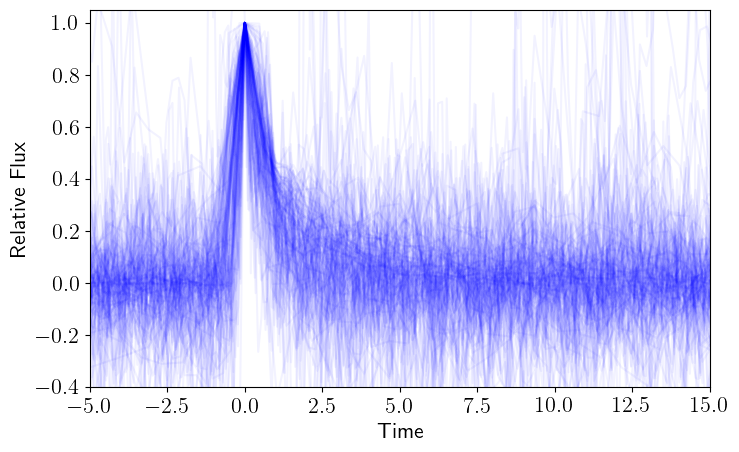

In [29]:

x_all=np.array([])
y_all=np.array([])
y_err = np.array([])
gp_st_dev = np.array([])
xmin=-5
xmax=15


for i in range(0,len(tess_flares)):
        x_new = (df['time'].values - time_max[i])/(t_halfs[i])
        y_new = ((detrended)/(peaks[i]))
        plt.plot(x_new,y_new,color='b',alpha=0.05)

        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.4,1.05)
        plt.xlim(-5,15)
        
        #Time Arrays
        nxs = np.where((x_new <= xmax) & (x_new>=xmin))[0]
        x_all = np.append(x_all,x_new[nxs])
        
        #Flux Arrays
        y_all = np.append(y_all,y_new[nxs])
        
        #Flux Errors
        flux_err = df['df_flux_err'].values/peaks[i] 
        y_err = np.append(y_err,flux_err[nxs])
        
        #GP Standard Deviation
        st_dev = df['std'].values/peaks[i]
        gp_st_dev = np.append(gp_st_dev,st_dev[nxs])
                  
#plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

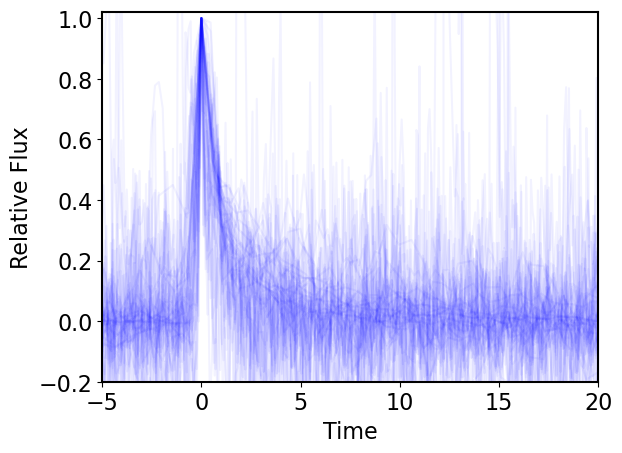

In [210]:
x_all_classic=np.array([])
y_all_classic=np.array([])
y_err_classic = np.array([])
gp_st_dev_classic = np.array([])
xmin=-5
xmax=15
for i in range(0,len(classical_flares)):
        x_new2 = (df['time'].values - time_max2[i])/(t_halfs2[i])
        y_new2 = ((detrended)/(peaks2[i]))
        plt.plot(x_new2,y_new2,color='b',alpha=0.05)

        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.2,1.02)
        plt.xlim(-5,20)
        
        #Time Arrays
        nxs2 = np.where((x_new2 <= xmax) & (x_new2>=xmin))[0]
        x_all_classic = np.append(x_all_classic,x_new2[nxs2])
        
        #Flux Arrays
        y_all_classic = np.append(y_all_classic,y_new2[nxs2])
        
        #Flux Errors
        flux_err_classic = df['df_flux_err'].values/peaks2[i] 
        y_err_classic = np.append(y_err_classic,flux_err_classic[nxs2])
        
        #GP Standard Deviation
        st_dev_classic = df['std'].values/peaks2[i]
        gp_st_dev_classic = np.append(gp_st_dev_classic,st_dev_classic[nxs2])

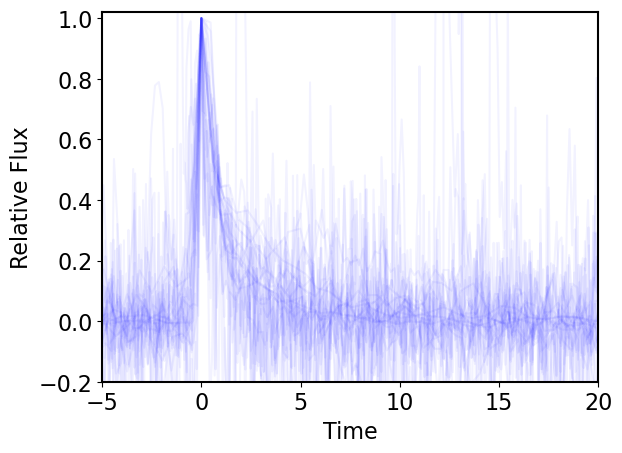

In [244]:
x_all_classic_vet=np.array([])
y_all_classic_vet=np.array([])
y_err_classic_vet = np.array([])
gp_st_dev_classic_vet = np.array([])
xmin=-5
xmax=20
for i in range(0,len(cross_match)):
        x_new2 = (df['time'].values - time_max2[i])/(t_halfs2[i])
        y_new2 = ((detrended)/(peaks2[i]))
        plt.plot(x_new2,y_new2,color='b',alpha=0.05)

        plt.xlabel('Time')
        plt.ylabel('Relative Flux')
        plt.ylim(-0.2,1.02)
        plt.xlim(-5,20)
        
        #Time Arrays
        nxs2 = np.where((x_new2 <= xmax) & (x_new2>=xmin))[0]
        x_all_classic_vet = np.append(x_all_classic_vet,x_new2[nxs2])
        
        #Flux Arrays
        y_all_classic_vet = np.append(y_all_classic_vet,y_new2[nxs2])
        
        #Flux Errors
        flux_err_classic = df['df_flux_err'].values/peaks2[i] 
        y_err_classic_vet = np.append(y_err_classic_vet,flux_err_classic[nxs2])
        
        #GP Standard Deviation
        st_dev_classic = df['std'].values/peaks2[i]
        gp_st_dev_classic_vet = np.append(gp_st_dev_classic_vet,st_dev_classic[nxs2])

In [245]:
#saving the arrays to a file
#dict_i = {'time':x_all_classic_vet,'flux': y_all_classic_vet, 'flux_err': y_err_classic_vet, 'gp_st_dev': gp_st_dev_classic_vet} 
#tess_classic_flares_vet = pd.DataFrame(data=dict_i) 
#tess_classic_flares_vet.to_csv(r'tess_classic_stacked_flare_values_vetted.csv',header=True,index=True)


In [ ]:
#saving the arrays to a file
#dict_i = {'time':x_all,'flux': y_all, 'flux_err': y_err, 'gp_st_dev': gp_st_dev} 
#tess_stacked_flares = pd.DataFrame(data=dict_i) 
#tess_stacked_flares.to_csv(r'tess_stacked_flare_values.csv',header=True,index=True)


In [31]:
tess_stacked_flare_vals=pd.read_csv('tess_stacked_flare_values.csv')

Text(0, 0.5, 'Relative Flux')

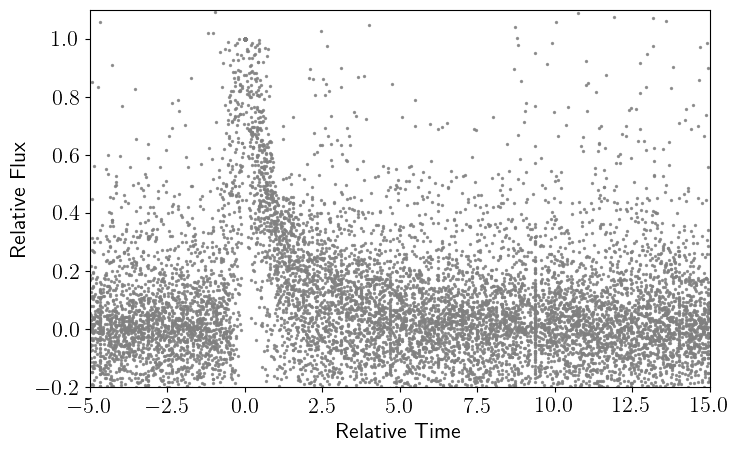

In [32]:
#INCLUDES ALL FLARES
tess_time = tess_stacked_flare_vals['time'].values
tess_flux = tess_stacked_flare_vals['flux'].values
tess_flux_err = tess_stacked_flare_vals['flux_err'].values
tess_gp_err = tess_stacked_flare_vals['gp_st_dev'].values

tess_both_errors = np.sqrt( (tess_flux_err)**2 + (tess_gp_err)**2 )

tess_sort = np.argsort(tess_time)
plt.scatter(tess_time[tess_sort],tess_flux[tess_sort],alpha=.8,s=8,marker='.',color='grey')
plt.ylim(-0.2,1.1)
plt.xlim(-5,15)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.savefig('/Users/lupitatovar/flares/figures/fit_stacked_flares.png',bbox_inches='tight')

Text(0, 0.5, 'Relative Flux')

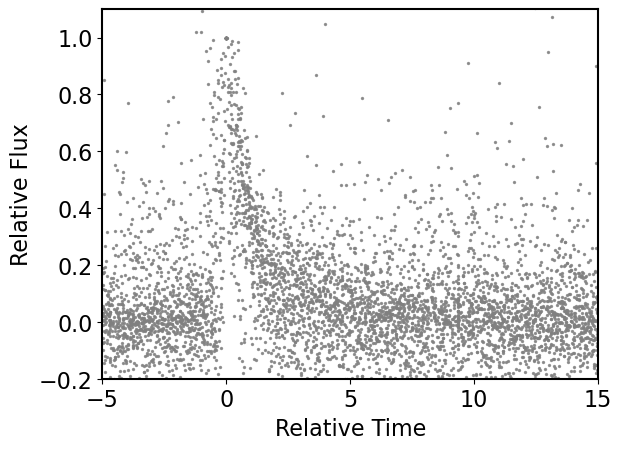

In [212]:
#INCLUDES ONLY CLASSIC FLARES
tess_classics=pd.read_csv('tess_classic_stacked_flare_values.csv')

time_classical = tess_classics['time'].values
flux_classical = tess_classics['flux'].values
flux_err_classical = tess_classics['flux_err'].values
gp_err_classical = tess_classics['gp_st_dev'].values

both_errors_classical = np.sqrt( (flux_err_classical)**2 + (gp_err_classical)**2 )

classic_sort = np.argsort(time_classical)
plt.scatter(time_classical[classic_sort],flux_classical[classic_sort],alpha=.8,s=8,marker='.',color='grey')
plt.ylim(-0.2,1.1)
plt.xlim(-5,15)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.savefig('/Users/lupitatovar/flares/figures/fit_stacked_flares.png',bbox_inches='tight')

In [214]:
print(len(tess_time))
print(len(time_classical))

10586
5350


In [ ]:
print(tess_sort)
print(tess_time)
print(tess_time[tess_sort])

In [33]:
from scipy import special
def flare_model(t,tpeak, fwhm, ampl):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    return flare * ampl

In [34]:
from scipy.stats import binned_statistic

def aflare1(t, tpeak, fwhm, ampl, upsample=False, uptime=10):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723
    Use this function for fitting classical flares with most curve_fit
    tools.
    Note: this model assumes the flux before the flare is zero centered
    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare
    upsample : bool
        If True up-sample the model flare to ensure more precise energies.
    uptime : float
        How many times to up-sample the data (Default is 10)
    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    if upsample:
        dt = np.nanmedian(np.diff(t))
        timeup = np.linspace(min(t)-dt, max(t)+dt, t.size * uptime)

        flareup = np.piecewise(timeup, [(timeup<= tpeak) * (timeup-tpeak)/fwhm > -1.,
                                        (timeup > tpeak)],
                                    [lambda x: (_fr[0]+                       # 0th order
                                                _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                                _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                                _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                                _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                     lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                                _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                    ) * np.abs(ampl) # amplitude

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t-dt/2.,[max(t)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',
                                 bins=downbins)

    else:
        flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                 (t > tpeak)],
                                [lambda x: (_fr[0]+                       # 0th order
                                            _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                            _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                            _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                            _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                                 lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                            _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                                ) * np.abs(ampl) # amplitude

    return flare

In [35]:
from scipy.stats import binned_statistic
def flare_model_v2(t,tpeak, fwhm, ampl, upsample=False, uptime=10):

    t_new = (t-tpeak)/fwhm +2
    #Note to user time needs to be sorted
    #consider adding a feat to sort t_new & needs to be unsorted at the end

    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    #[3.09376901,  3.74111441, -0.24209949,  0.11042946,  1.32430633,  0.17351056]
    #[2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    #if fwhm or ampl < 0:
    #return np.inf
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:
    
        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                                 + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
    
    erf_bound = 0.5*(special.erf((t_new-0.2)*100) + 1)
    
    return flare * ampl * erf_bound    

In [36]:
jim_model = aflare1(tess_time,0,1,1)
new_model = flare_model(tess_time,0,1,1)
model_v2 = flare_model_v2(tess_time,0,1,1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


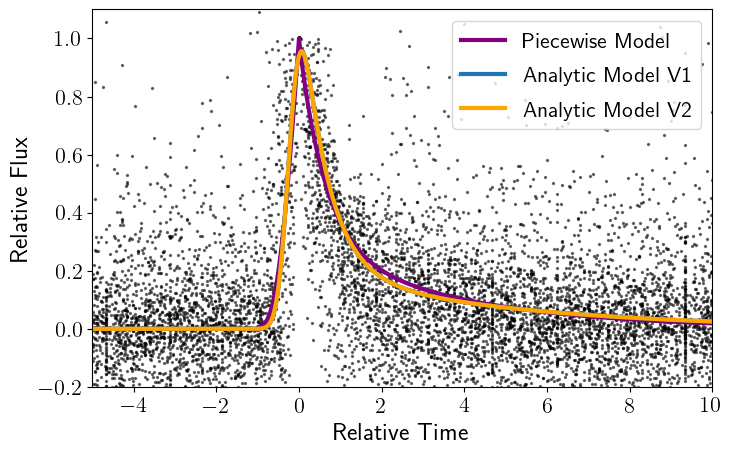

In [37]:
plt.scatter(tess_time[tess_sort],tess_flux[tess_sort],alpha=.5,s=8,marker='.',color='k')
plt.plot(tess_time[tess_sort],jim_model[tess_sort],color='purple',lw=3,label='Piecewise Model')
plt.plot(tess_time[tess_sort],new_model[tess_sort],color='C0',lw=3, label = 'Analytic Model V1')
plt.plot(tess_time[tess_sort],model_v2[tess_sort],color='orange',lw=3, label = 'Analytic Model V2')
plt.ylim(-0.2,1.1)
plt.xlim(-5,10)
plt.xlabel("Relative Time",fontsize='18')
plt.ylabel("Relative Flux",fontsize='18')
plt.legend( loc='upper right')#, borderaxespad=0.)
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_stacked_flares.pdf')

Stacking Procedure that uses cumulative distribution

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


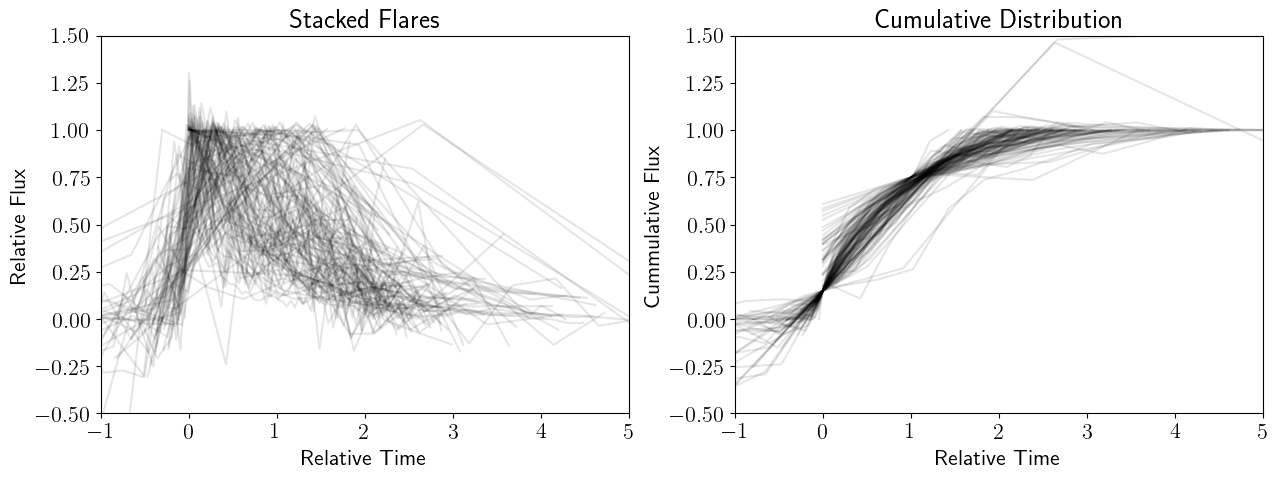

In [38]:
fig, axs = plt.subplots(1,2, figsize=(15, 5), facecolor='w', edgecolor='k')

new_t_center2 = np.array([])          # time at 50% cummulative flux of each flare
new_scale_height2 = np.array([])  # mean flux of the entire flare 
new_scale_dur2 = np.array([])     # (t_75 - t_25)

#arrays that get saved into .csv
new_x_all2=np.array([])
new_y_all2=np.array([])
new_y_err2=np.array([])
new_gp_st_dev2=np.array([])

for i in range(0,len(tess_flares)):

    #Mask of the times (t_start and t_stop) between each flare 
    temp1 = np.where((df['time'] < tess_flares['t_stop'].values[i]) & 
                    (df['time'] > tess_flares['t_start'].values[i]))[0]
    
    # cummulative distribution of detrended fluxes within each flare
    cd_detrended1 = np.cumsum((detrended[temp1])/np.sum(detrended[temp1]))
    

    # interpolation over the flux of each flare: yvals are percentiles of cummulative flux & x_interp gives corresponding times
    # note that we are looking at times and fluxes in cummulative space
    
    yvals = np.array([0.15,0.25,0.75])
    new_xinterp = np.interp(yvals, cd_detrended1, df['time'].values[temp1])

    # t_50
    #cd_i_max = np.argmax(detrended[temp])
    #t_max = (df['time'].values[temp][cd_i_max])
    #cd_flux_max = (detrended[temp][cd_i_max])
    
    
    #double check this part
    t1 = new_xinterp[0]
    t2 = new_xinterp[1]#cd_flux_max / 2.0
    t3 = new_xinterp[2]
    
    new_t_center2 = np.append(new_t_center2,t1)
    
    #i_xs = np.where((xinterp[temp] > t_50_flux[i]))[0]
    #time_xs = yvals[temp][i_xs]
    
    # defining the scale height
    cd_mean1 = np.cumsum(detrended[temp1])    #explore this a little more (have tried mean, sum, median)
    #scale_height = np.append(scale_height,cd_mean)
    
    
    #testing interpolating over the fluxes instead of using mean flux
    height_interp = np.interp(0.99, np.linspace(0,1,len(detrended[temp1])), np.sort(detrended[temp1]))
    new_scale_height2 = np.append(new_scale_height2,height_interp)
    
    # scale duration

    diff_dur = np.abs(t3 - t2)
    new_scale_dur2 = np.append(new_scale_dur2,diff_dur)
    
    
    ######## PLOTTING ################

    new_x2 = (df['time'].values[temp1] - new_t_center2[i])/(new_scale_dur2[i])
    new_y2 = ((detrended[temp1])/(new_scale_height2[i]))
    
    
    
    #ax1.plot(xinterp,yvals,'o',color='orange', label= 'interp data')

    axs[0].plot(new_x2,new_y2,color='k',alpha=0.1)


    #axs[1].plot((xinterp[2]-xinterp)/new_scale_dur[i],yvals,'x',color='orange',alpha=0.2)
    axs[1].plot(new_x2,np.cumsum(new_y2)/np.sum(new_y2),color='k',alpha=0.1)
    
    #axs[1].scatter(df['time'][i]-xinterp[2],cd_detrended[i],color='k')#,alpha=0.5)
   

    #Setting Titles
    axs[0].set_title('Stacked Flares')
    axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    axs[0].set_xlabel("Relative Time")
    axs[0].set_ylabel("Relative Flux")    
    axs[1].set_ylabel("Cummulative Flux")
    axs[1].set_xlabel("Relative Time")

    #Axes limits
    axs[0].set_xlim(-1,5)
    axs[0].set_ylim(-0.5,1.5) 
    
    axs[1].set_xlim(-1,5)
    axs[1].set_ylim(-.5,1.5)
    #Legend
    #ax1.legend(loc='lower right')

    ########### Saving Arrays ########################
    
    # time array
    new_x_all2 = np.append(new_x_all2,new_x2)
        
    #Flux Array
    new_y_all2 = np.append(new_y_all2,new_y2)
        
       
        
        #    
    #i_max = np.argmax(detrended[temp])
    #flux_max = (detrended[temp][i_max])
    #new_peaks = np.append(new_peaks,flux_max)
        
    #Flux Errors
    
    new_flux_err2 = df['df_flux_err'].values[temp1]/new_scale_height2[i] 
    new_y_err2 = np.append(new_y_err2,new_flux_err2)
        
    #GP Standard Deviation
    
    new_st_dev2 = df['std'].values[temp1]/new_scale_height2[i]
    new_gp_st_dev2 = np.append(new_gp_st_dev2,new_st_dev2)   
    #plt.savefig('stack_cd.png',bbox_inches='tight')

In [ ]:
print(df['time'][temp1].values)
print(df['time'].values[temp1])


Saving the values that create the stacked plot into a .csv file

In [40]:
#dict_n = {'time':new_x_all2,'flux': new_y_all2, 'flux_err': new_y_err2, 'gp_st_dev': new_gp_st_dev2} 
#new_stack_arrays_tess = pd.DataFrame(data=dict_n) 
#new_stack_arrays_tess.to_csv(r'new_stack_arrays_tess.csv',header=True,index=True)

In [39]:
tess2_stack=pd.read_csv('new_stack_arrays_tess.csv')

(-2.0, 5.0)

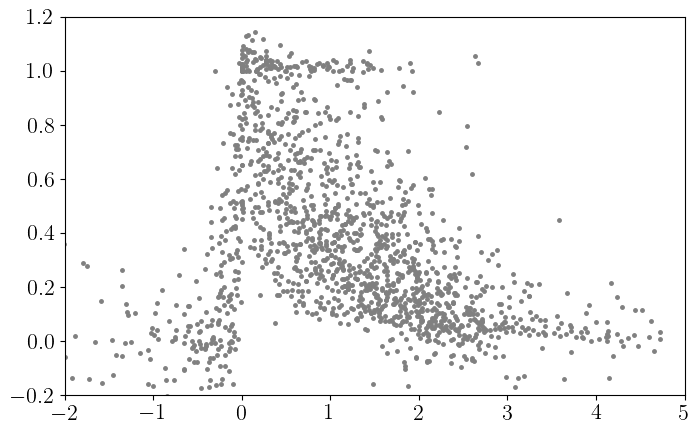

In [40]:
tiempo = tess2_stack['time'].values
flujo = tess2_stack['flux'].values
flujo_err = tess2_stack['flux_err'].values
gp_err = tess2_stack['gp_st_dev'].values
dos_errors = np.sqrt( (flujo_err)**2 + (gp_err)**2 )

sorter = np.argsort(tiempo)
plt.scatter(tiempo,flujo,s=25,marker='.',color='grey')
plt.ylim(-0.2,1.2)
plt.xlim(-2,5)

In [43]:
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 25
#rcParams["figure.figsize"] = [8, 4]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ['Verdana']#["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

Text(0, 0.5, 'Relative Flux')

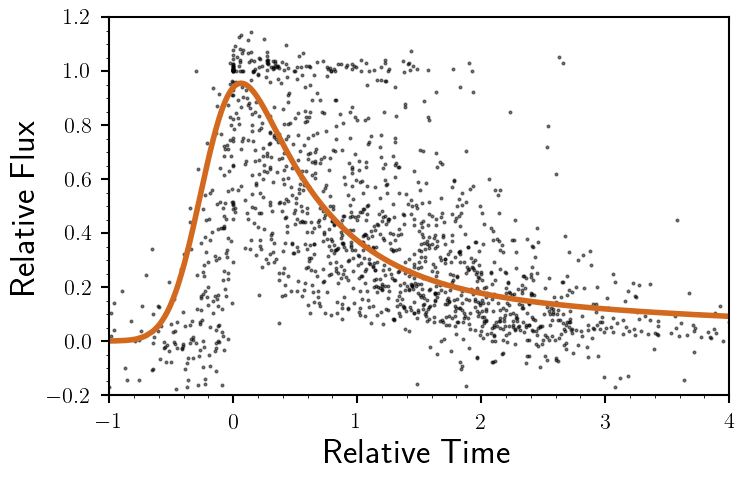

In [41]:
#plt.plot(tiempo[sorter],aflare1(tiempo[sorter],0,1,1),color='purple',lw=3,label='Piecewise Model')
#plt.plot(tiempo[sorter]-2,flare_model(tiempo,0,1,1)[sorter],color='C0',lw=3, label = 'Analytic Model V1')

plt.figure(figsize=(8,5))
plt.rcParams['axes.linewidth']=1.5
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()

plt.plot(tiempo[sorter],flare_model_v2(tiempo[sorter],0,1,1),color='chocolate',lw=4, label = 'Analytic Model')


plt.scatter(tiempo,flujo,alpha=.5,s=15,marker='.',color='k')
plt.ylim(-0.2,1.2)
plt.xlim(-1,4)

plt.xlabel("Relative Time",fontsize='25')
plt.ylabel("Relative Flux",fontsize='25')
#plt.legend()
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_newstack.png',bbox_inches='tight')

Trying out the final stacking procedure that we used for the paper

In [ ]:
print(detrended)

In [ ]:
tess_flares

CurveFit -- Fits each individual flare using our new model

In [42]:
from scipy.optimize import least_squares,curve_fit, minimize

In [43]:
 #defining the error array to feed into curvefit
error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))
print(error1)

[0.00143194 0.00142572 0.00141977 ... 0.00175748 0.00176062 0.00177   ]


In [44]:
print(len(tess_flares))
print(len(classical_flares))

132
47


In [45]:
np.isnan(tess_flares['t_stop'].values - tess_flares['t_start'].values)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

Stacking only the classical tess flares and saving the corresponding arrays

In [46]:
tpeaks2 = [] 
fwhms2 = [] 
amps2 = []

tpeaks_err2 = []
fwhms_err2 = []
amps_err2 = []

#t,tpeak, fwhm, ampl
for i in range (0,len(classical_flares)):

    #Defining times of each flare event
    i_temp2 = np.where((df['time'].values <= (classical_flares['t_stop'].values[i]+0.01)) & 
                    (df['time'].values >= (classical_flares['t_start'].values[i]-0.005)))[0]
    
    peak_flujo2 = classical_flares['t_stop'].values - classical_flares['t_start'].values
    
    #arrays to feed to curvefit
    x_fit2 = df['time'].values[i_temp2]
    y_fit2 = detrended[i_temp2]
    
    #initial values
    init_vals2= [classical_flares['t_peak'].values[i],  peak_flujo2[i]/4,classical_flares['Flux_peak'].values[i]]
    
    #running curvefit
    best_vals2, covar2 = curve_fit(flare_model_v2, x_fit2, y_fit2, p0=init_vals2, maxfev=10000, sigma= error1[i_temp2],
                                  bounds=[[min(x_fit2),0,0],[max(x_fit2),peak_flujo2[i],3*max(y_fit2)]])
    #print('best_vals: {}'.format(best_vals2))
    
    err2 = np.sqrt(np.diag(covar2))
    
    ############# Saving Output Arrays ################
    tpeaks2 = np.append(tpeaks2,best_vals2[0])
    fwhms2 = np.append(fwhms2,best_vals2[1])
    amps2 = np.append(amps2,best_vals2[2])
    
    tpeaks_err2 = np.append(tpeaks_err2,err2[0])
    fwhms_err2 = np.append(fwhms_err2,err2[1])
    amps_err2 = np.append(amps_err2,err2[2])


In [ ]:
#dict_n = {'time':new_x_all2,'flux': new_y_all2, 'flux_err': new_y_err2, 'gp_st_dev': new_gp_st_dev2} 
#new_stack_arrays_tess = pd.DataFrame(data=dict_n) 
#new_stack_arrays_tess.to_csv(r'new_stack_arrays_tess.csv',header=True,index=True)

In [237]:
len(classical_flares)

47

In [ ]:
print(classical_flares['t_peak'].values[0])
print(classical_flares['Flux_peak'].values[0]/2) 
print(peak_flujo2[0])

In [ ]:
print(x_fit2)
print(y_fit2)

In [ ]:
print(len(df['time'].values))
print(len(detrended))
print(len(error1))

In [ ]:
print(len(tpeaks2))
print(len(classical_flares))
print(best_vals2[0])

In [ ]:
print(len(covar2))
print(len(err2))
print(len(tpeaks_err2))
print(len(fwhms_err2))
print(len(amps_err2))

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


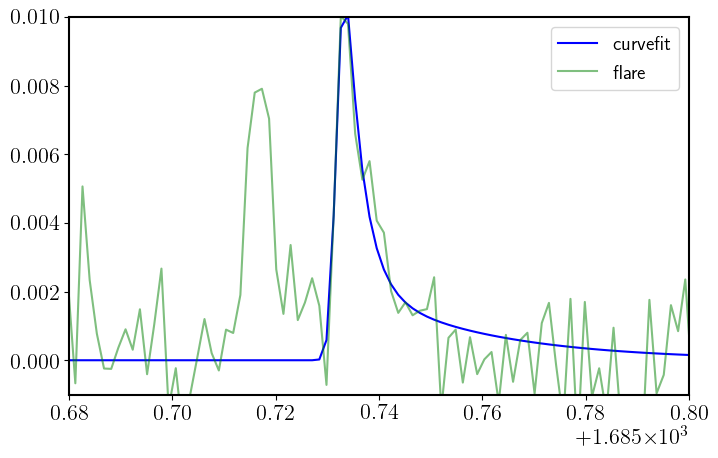

In [47]:
plt.plot(df['time'],flare_model_v2(df['time'],tpeaks2[0],fwhms2[0],amps2[0]),color='b',label='curvefit')
#plt.plot(df['time'],flare_model_v2(df['time'],*init_vals2),color='orange',label='init guess')
plt.plot(df['time'],detrended,color='green',label='flare',alpha=0.5)
plt.xlim(1685.68,1685.8)
plt.ylim(-0.001,0.01)
plt.legend(loc='upper right',fontsize='14')

Stacking the curvefit fits usuing the D14 stacking procedure

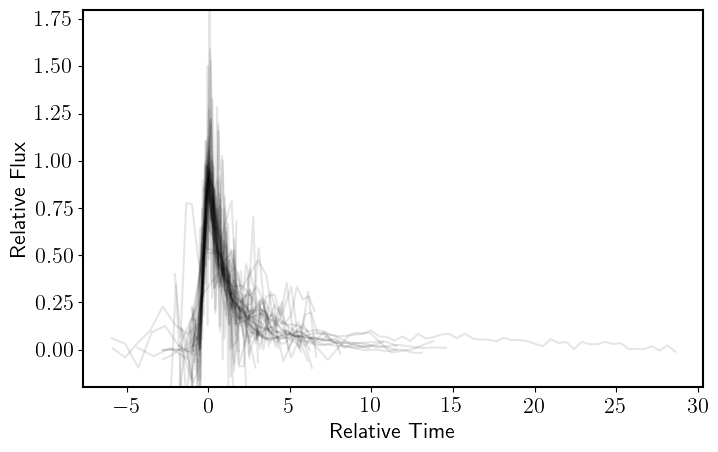

In [48]:
time_stack_fits2=np.array([])
flux_stack_fits2=np.array([])
stack_y_err2 = np.array([])
stack_gp_st_dev2 = np.array([])
xlim1=-5
xlim2=20
ylim1= -0.2
ylim2= 1.8

#plt.figure( figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(classical_flares)):
 
    
    #coeffs array already has these values: tpeak(time_max), fwhm(t_half), ampl(peak)
    # defining the variable to plot
    i_temp2 = np.where((df['time'].values <= classical_flares['t_stop'].values[i]) & 
                    (df['time'].values >= classical_flares['t_start'].values[i]))[0]
    
    temp_x_stack2 = (df['time'].values[i_temp2] - tpeaks2[i])/(fwhms2[i])
    temp_y_stack2 = ((detrended[i_temp2])/(amps2[i]))
    plt.plot(temp_x_stack2,temp_y_stack2,color='black',alpha=0.1)


    #Time Arrays
    nxs2 = np.where((temp_x_stack2 <= xlim2) & (temp_x_stack2>=xlim1)& (temp_y_stack2 <= ylim2) & (temp_y_stack2>=ylim1))[0]
    time_stack_fits2 = np.append(time_stack_fits2,temp_x_stack2[nxs2])
        
    #Flux Arrays
    flux_stack_fits2 = np.append(flux_stack_fits2,temp_y_stack2[nxs2])
        
    #Flux Errors
    new_flux_err2 = df['df_flux_err'].values/tpeaks2[i] 
    stack_y_err2 = np.append(stack_y_err2,new_flux_err2[nxs2])
        
    #GP Standard Deviation
    new_st_dev2 = df['std'].values/tpeaks2[i]
    stack_gp_st_dev2 = np.append(stack_gp_st_dev2,new_st_dev2[nxs2])
                  
   
    
    ########## PLOTTING ################
    #plt.plot(temp_x_stack,temp_y_stack,color='k',alpha=0.01)

    #the plot below is in cumulative distribution space
    #plt.plot(temp_x_stack,np.cumsum(temp_y_stack)/np.sum(temp_y_stack),color='k')

   

    #Setting Titles
    #axs[0].set_title('Stacked Flares')
    #axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    plt.xlabel("Relative Time")
    plt.ylabel("Relative Flux")    
    #axs[1].set_ylabel("Cummulative Flux")
    #axs[1].set_xlabel("Relative Time")

    #Axes limits
    #plt.xlim(-1,20)
    plt.ylim(-0.2,1.8)
    
    
#plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
    

#plt.savefig('')


In [ ]:
df

In [ ]:
print(np.sum(np.isfinite(df['detrended_flux'].values)))
print(np.sum(np.isfinite(df['time'].values)))

Vetting flares

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarn

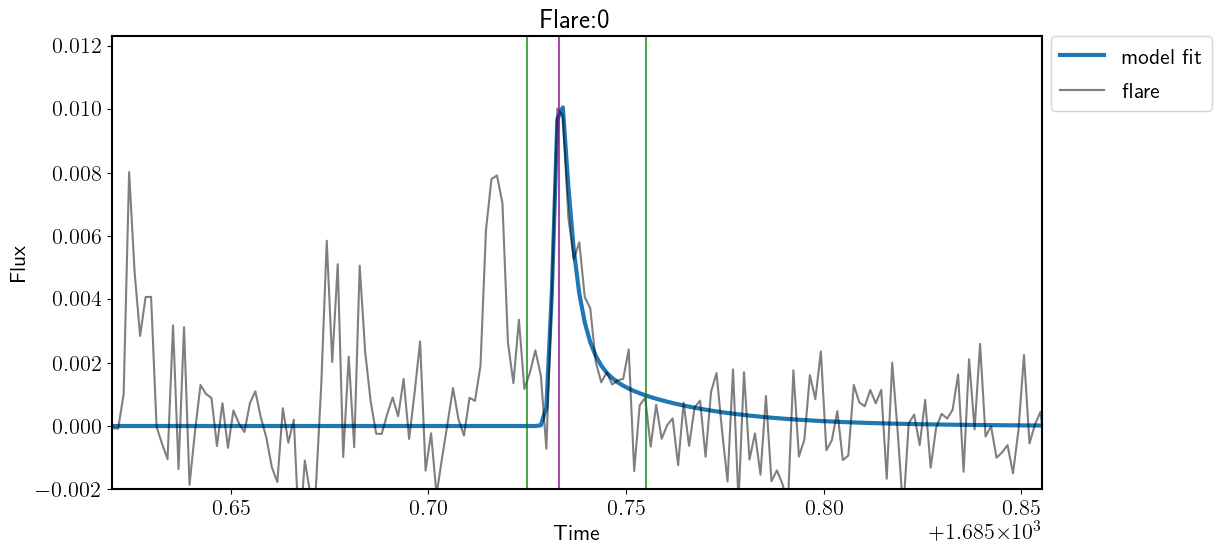

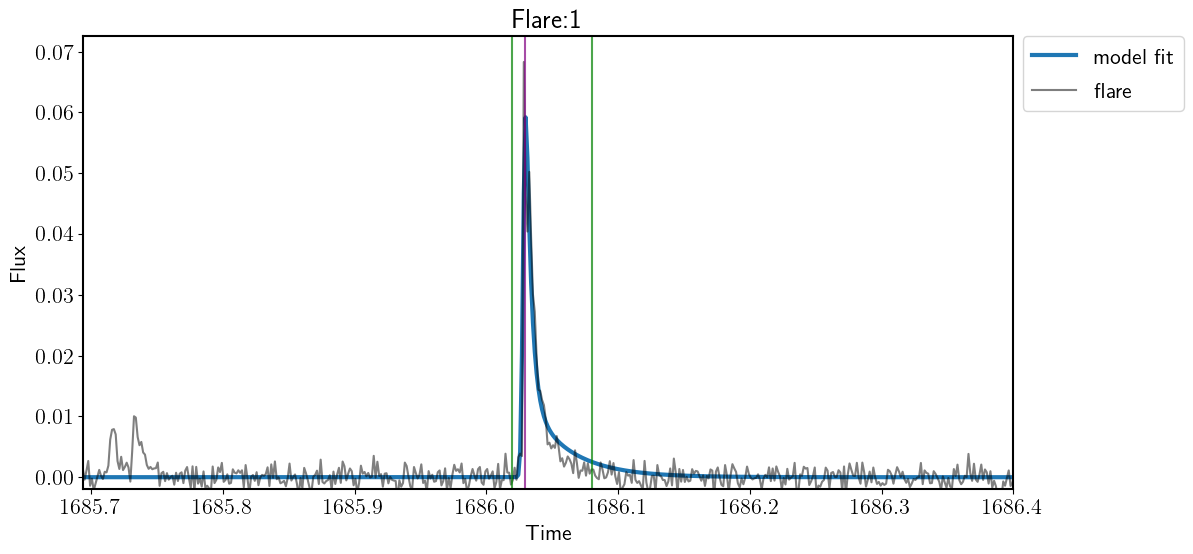

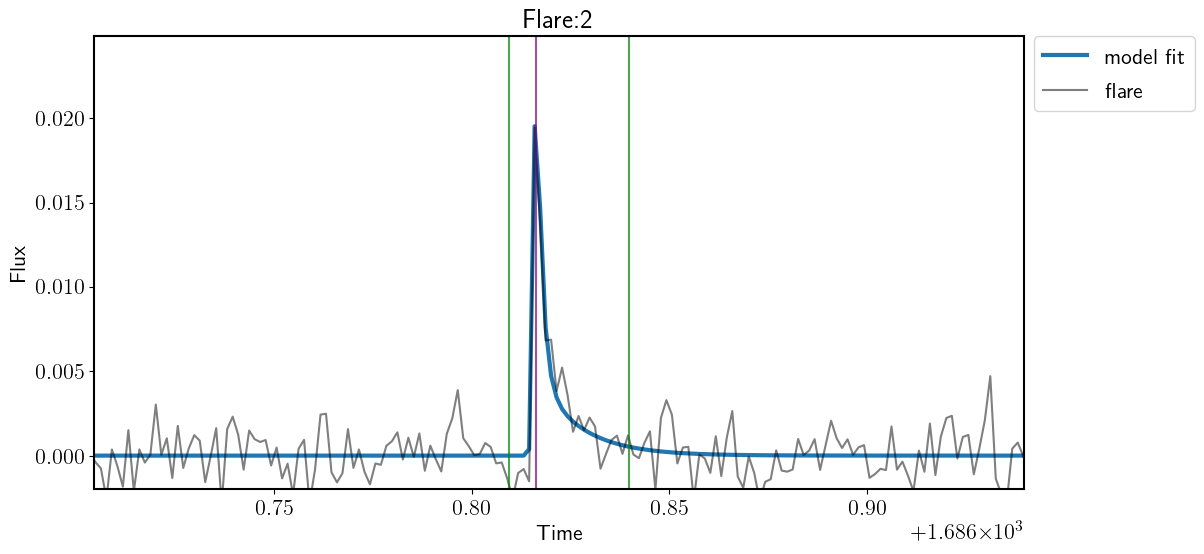

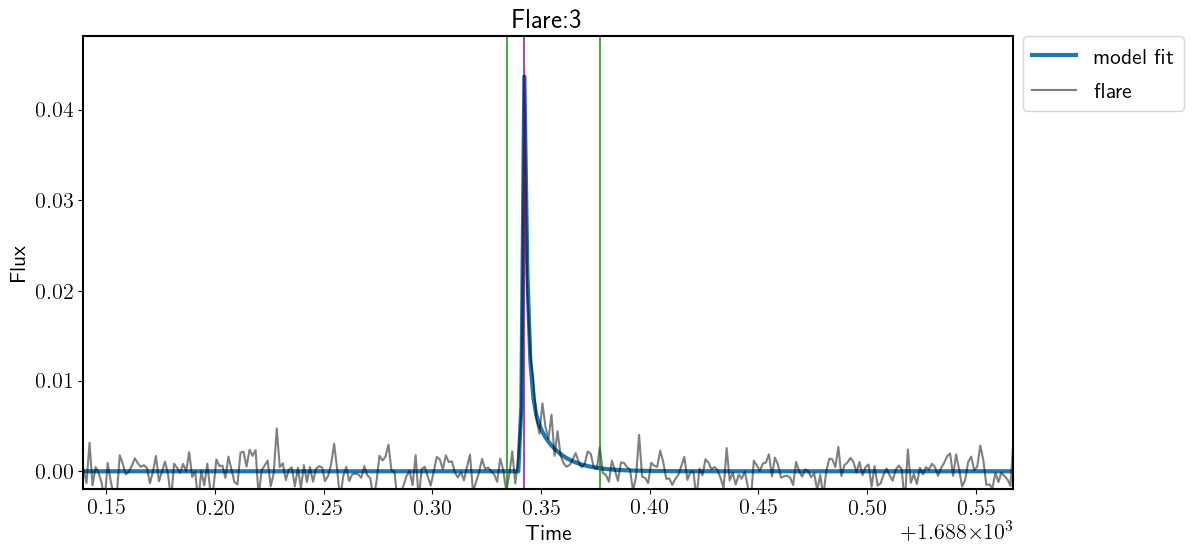

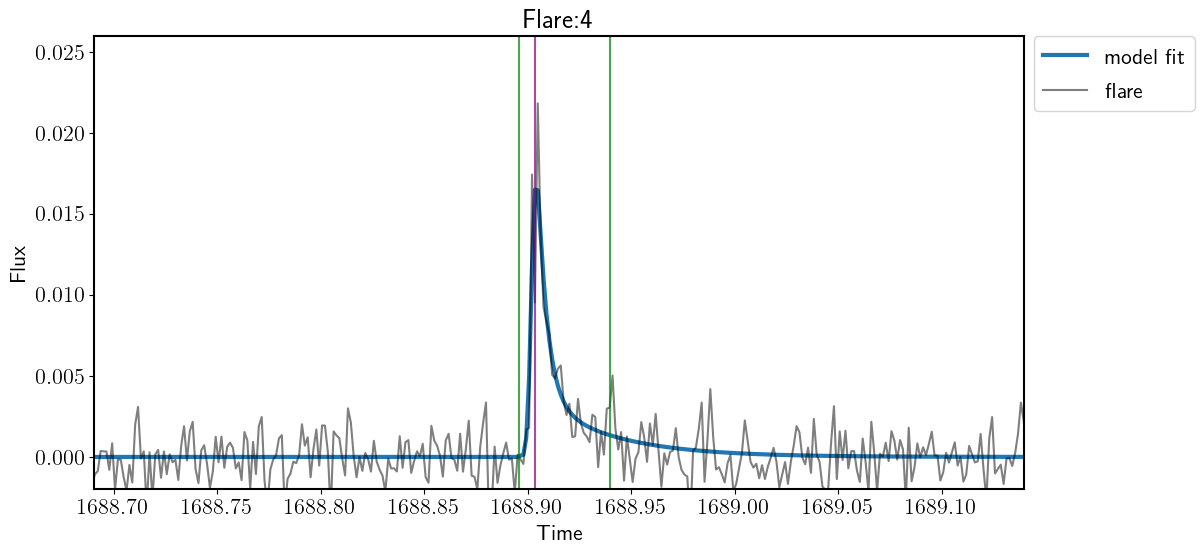

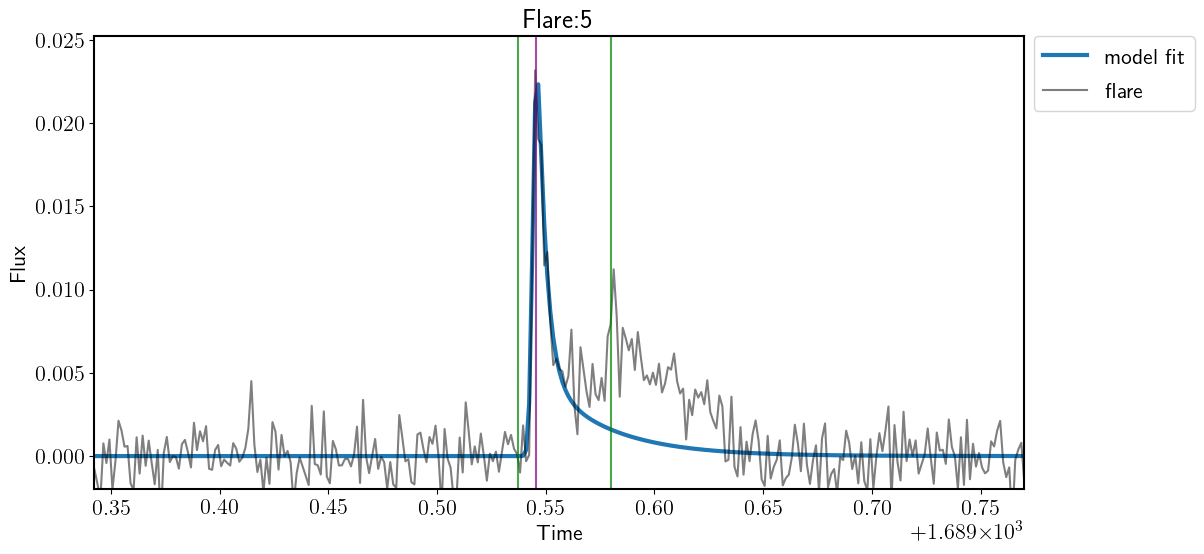

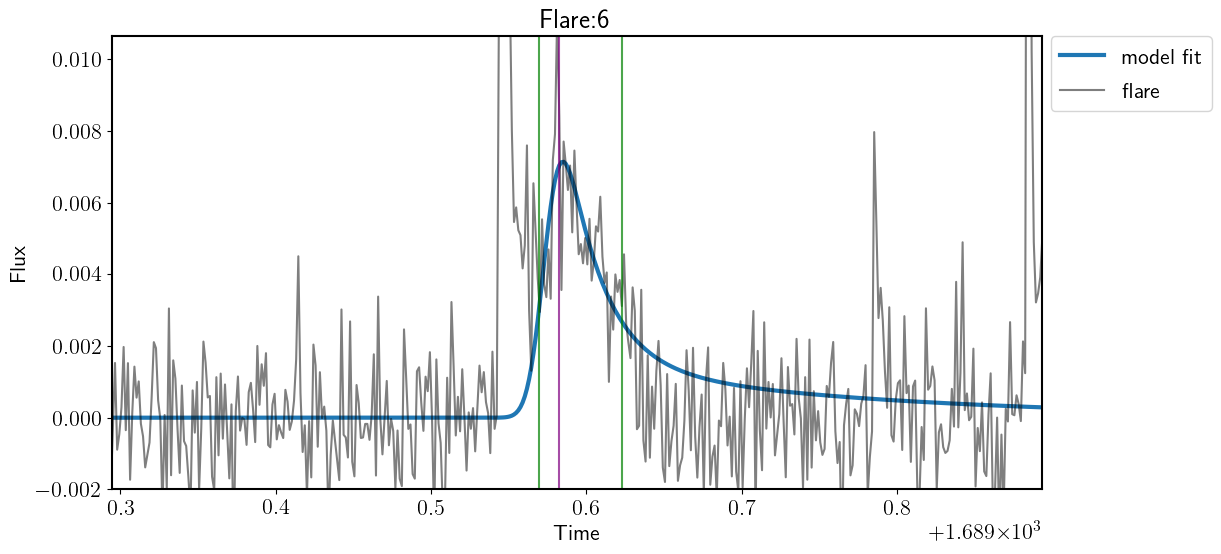

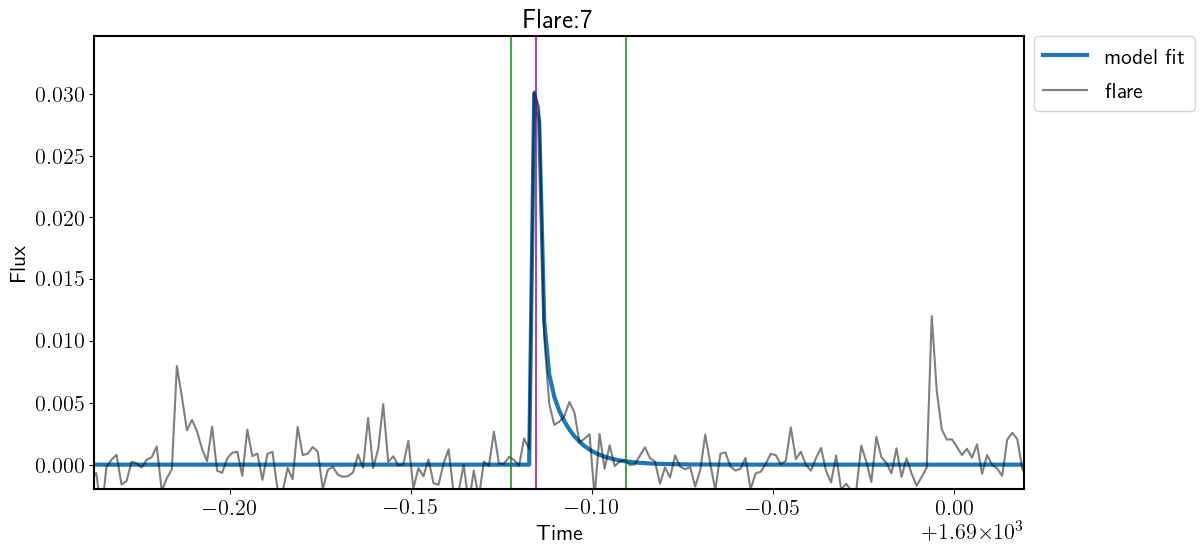

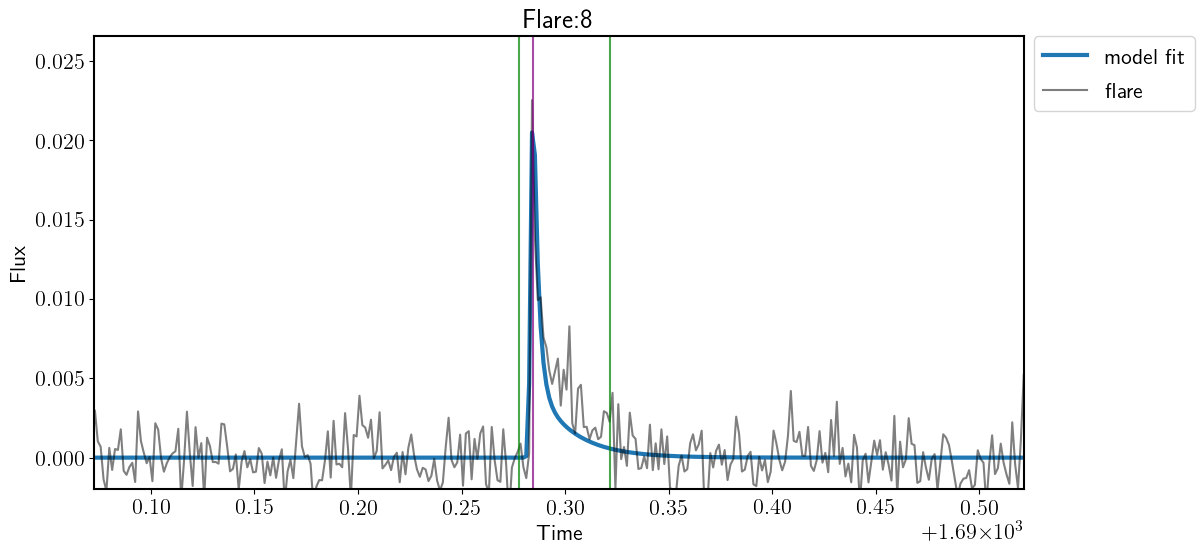

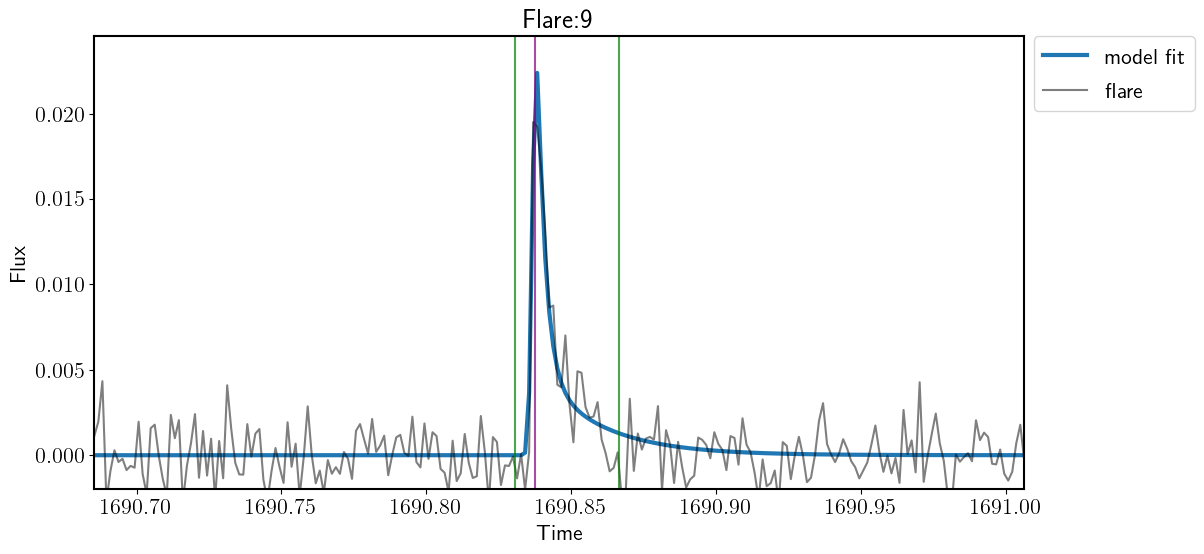

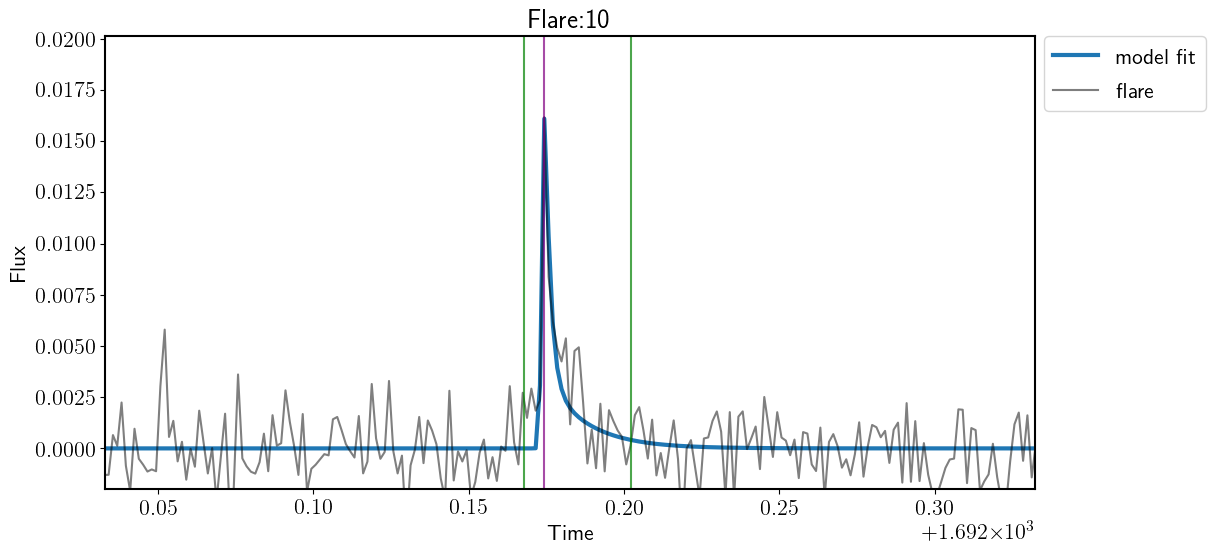

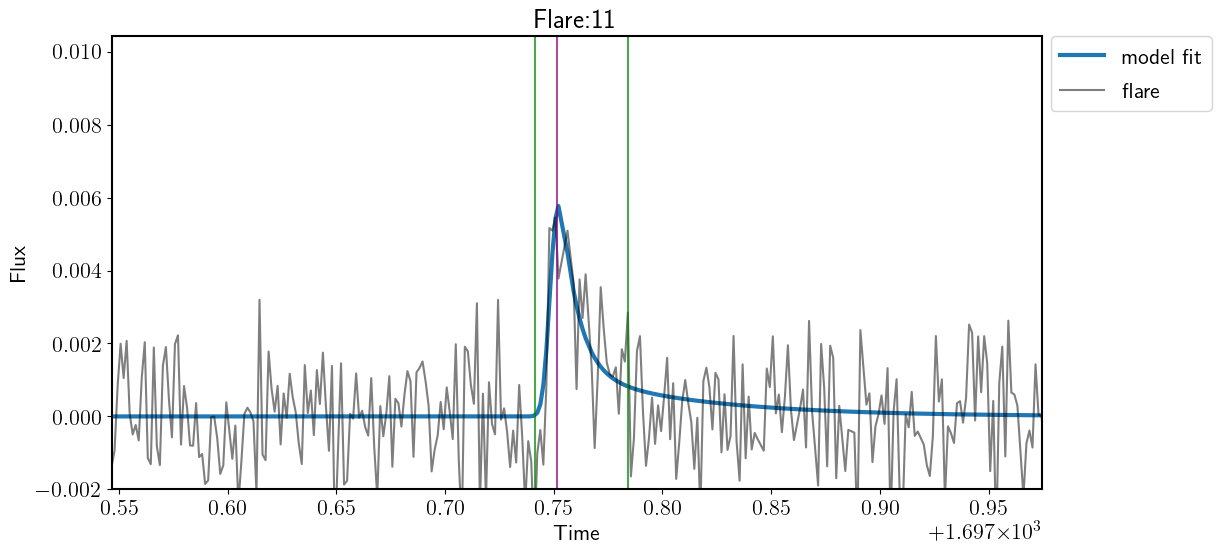

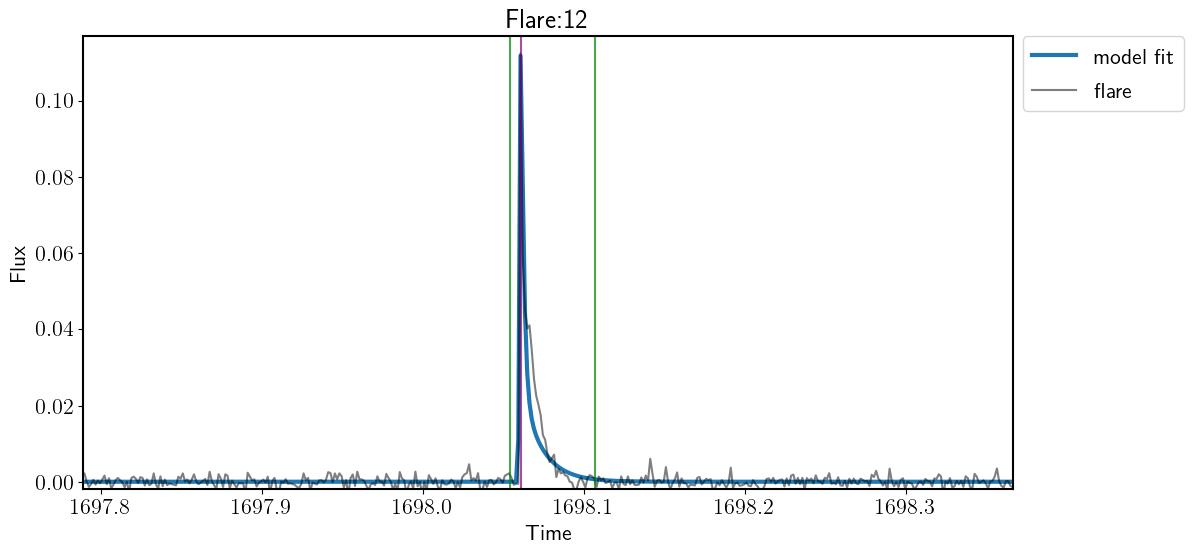

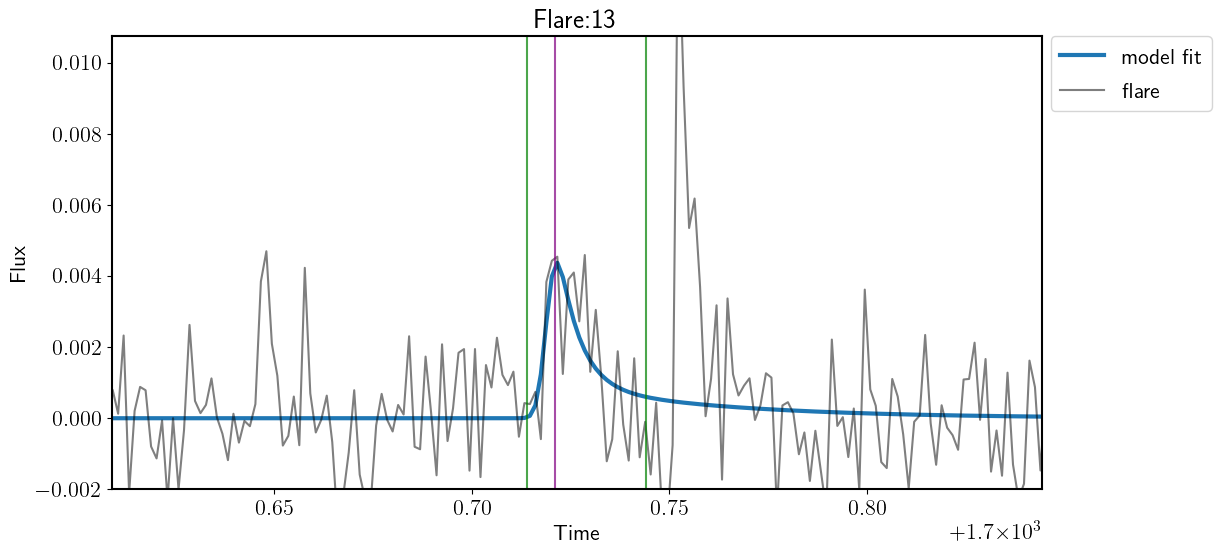

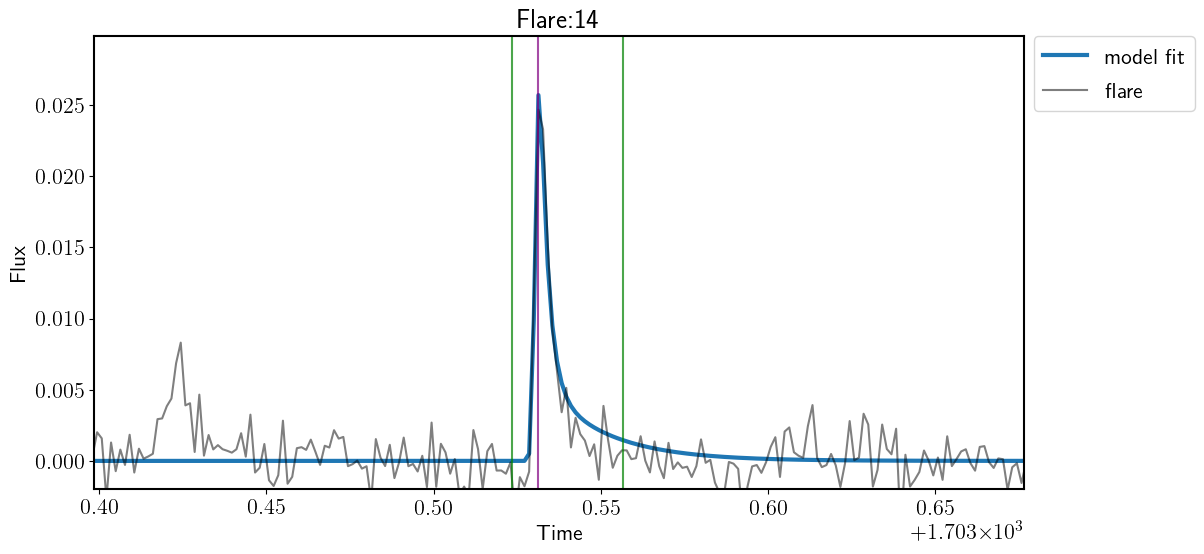

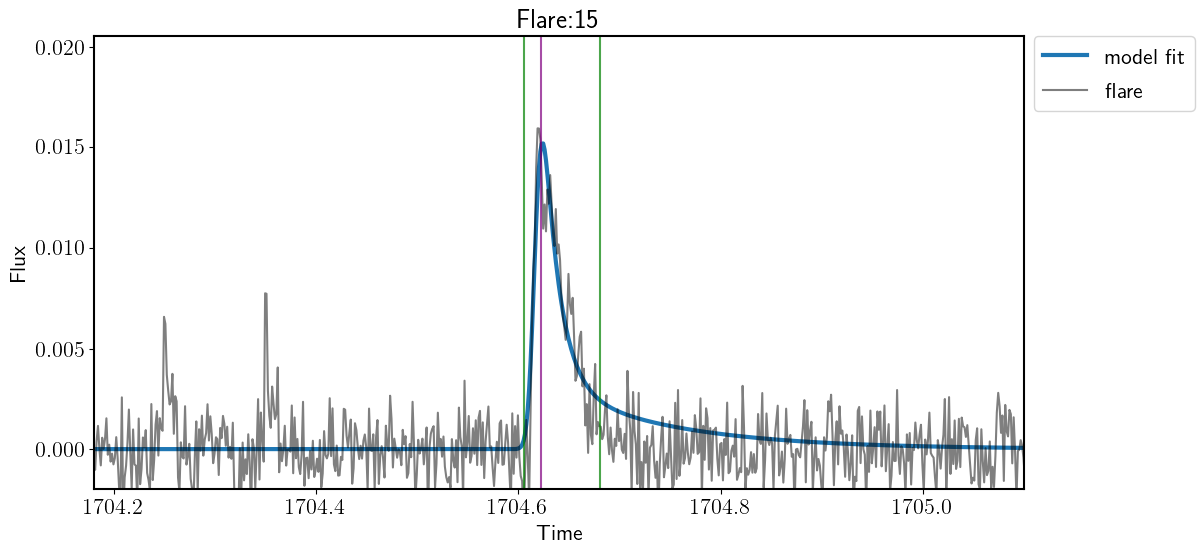

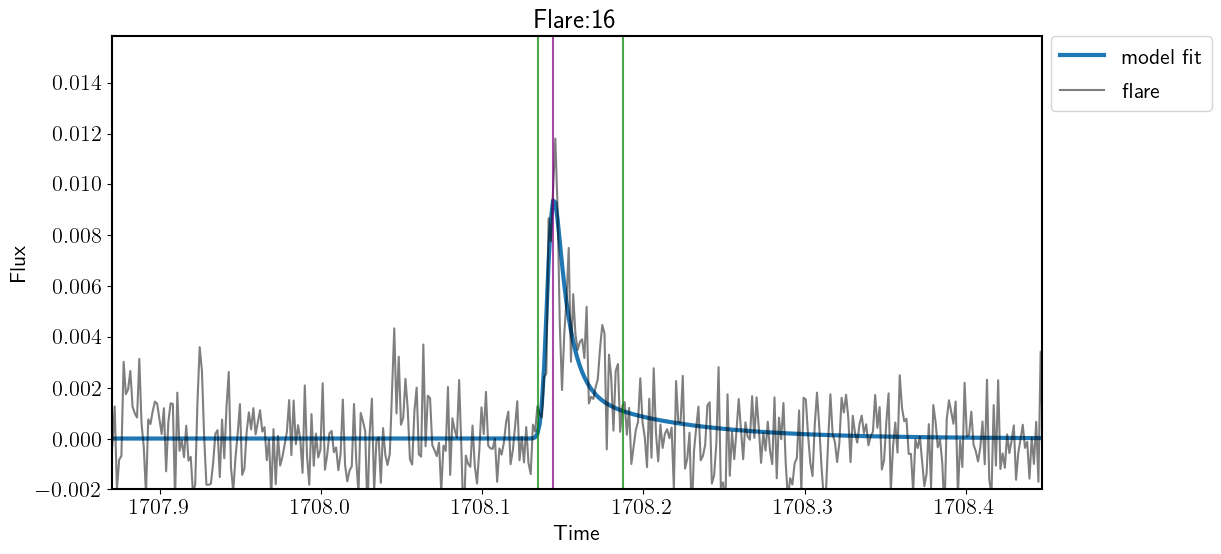

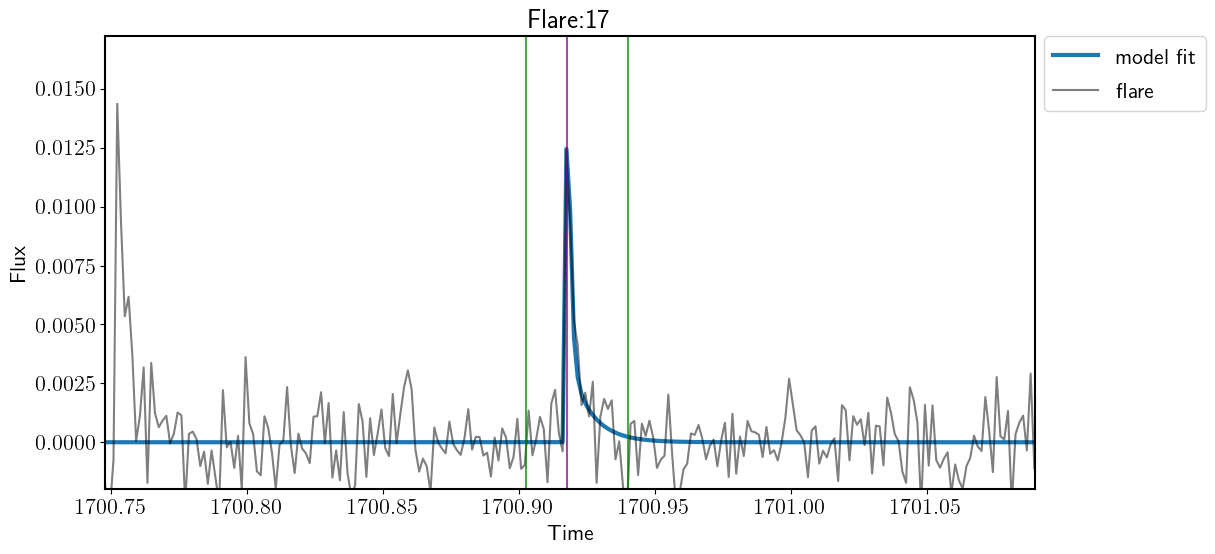

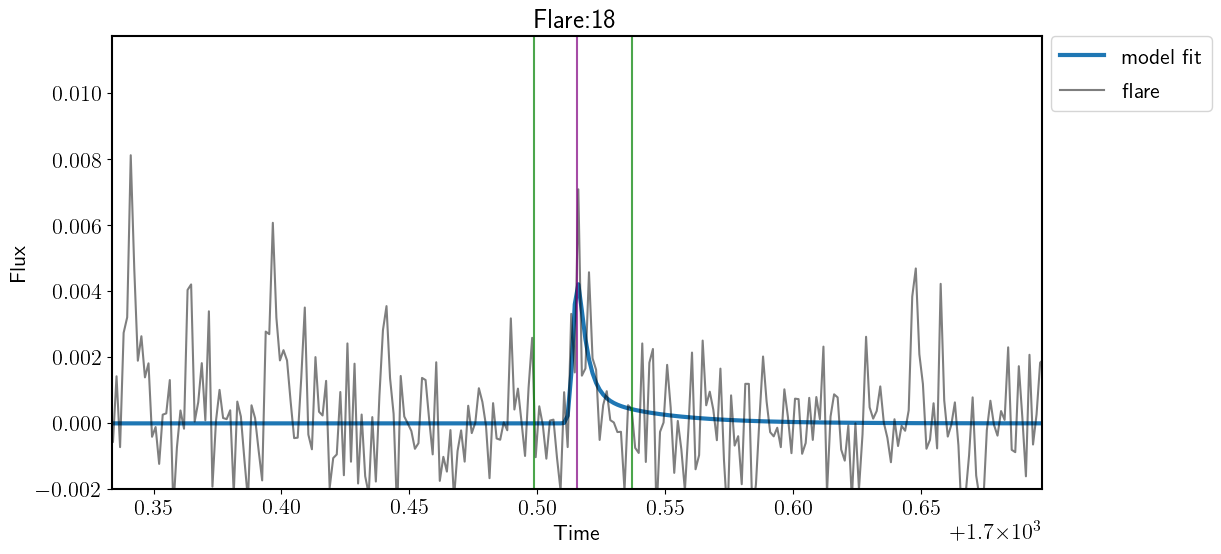

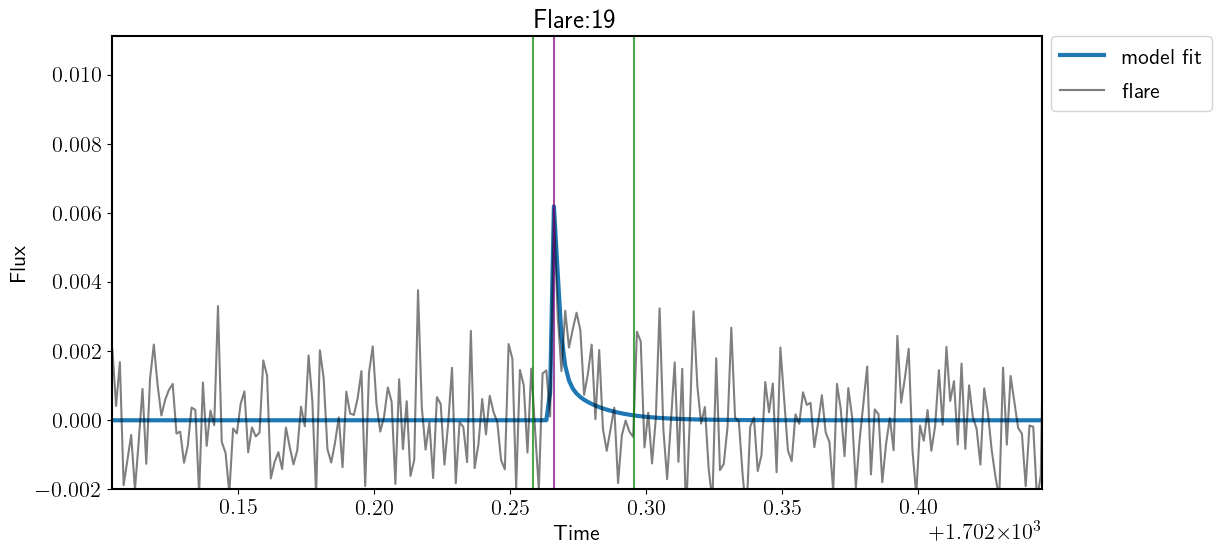

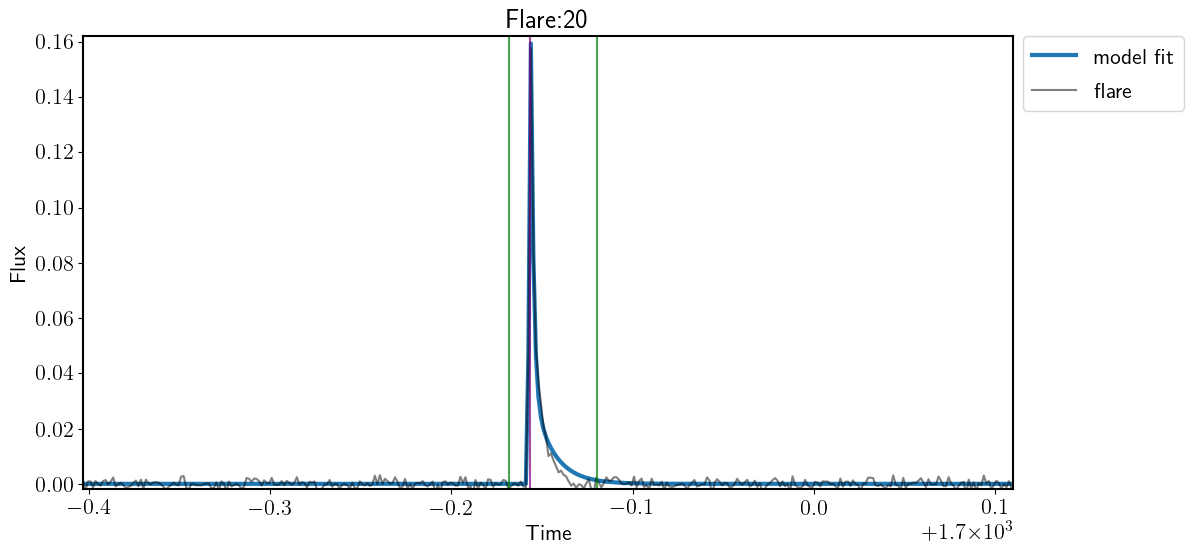

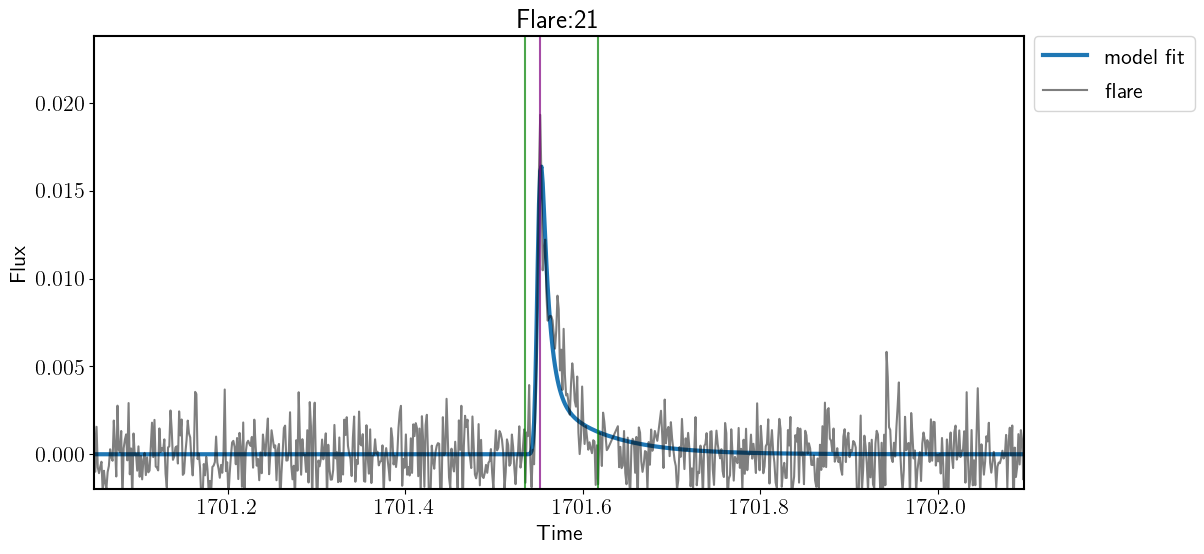

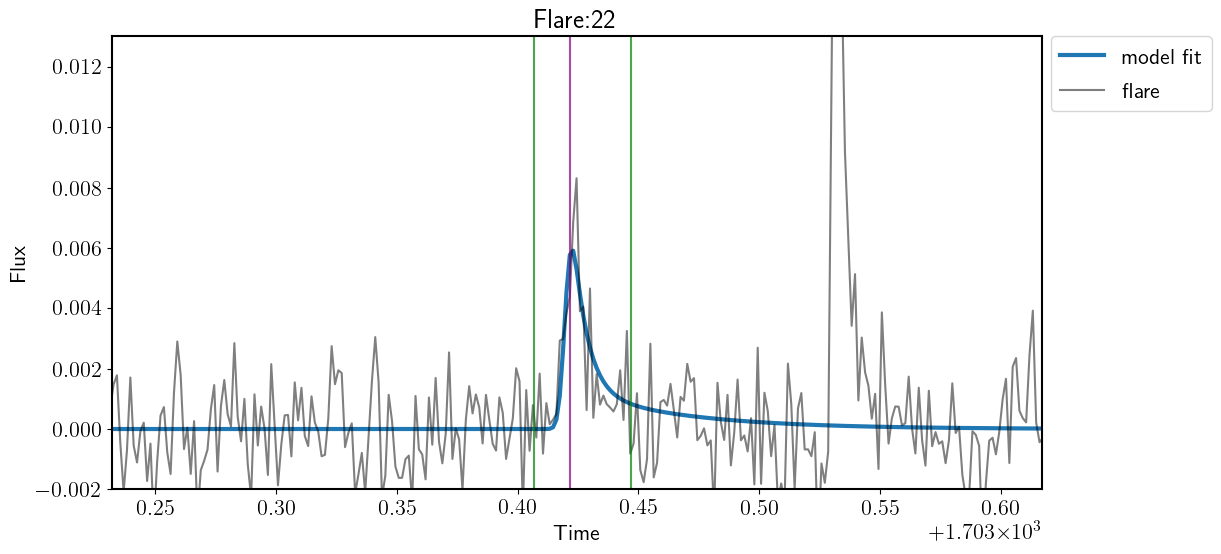

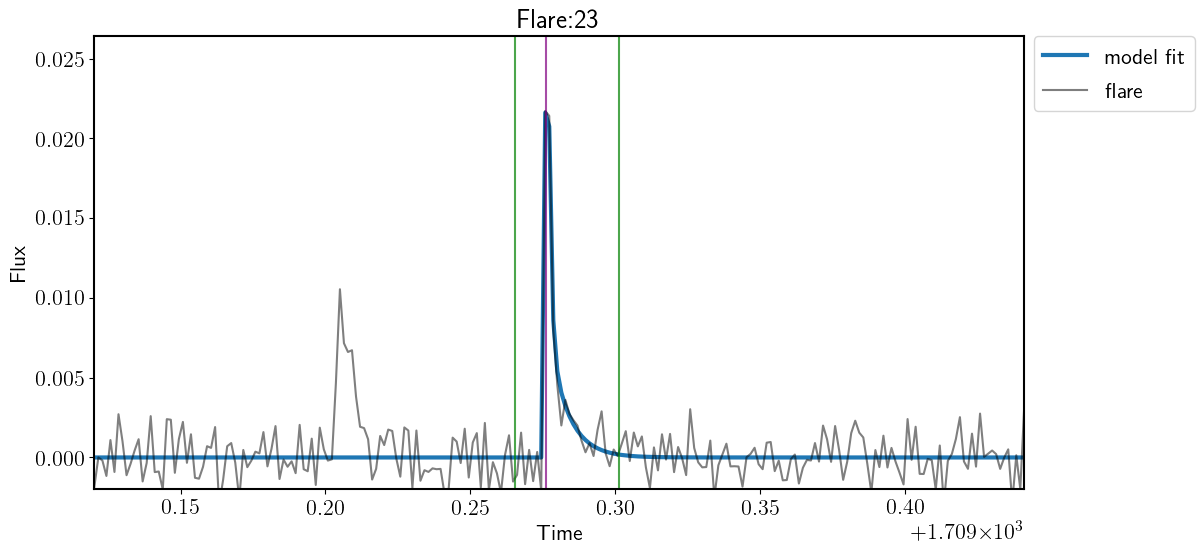

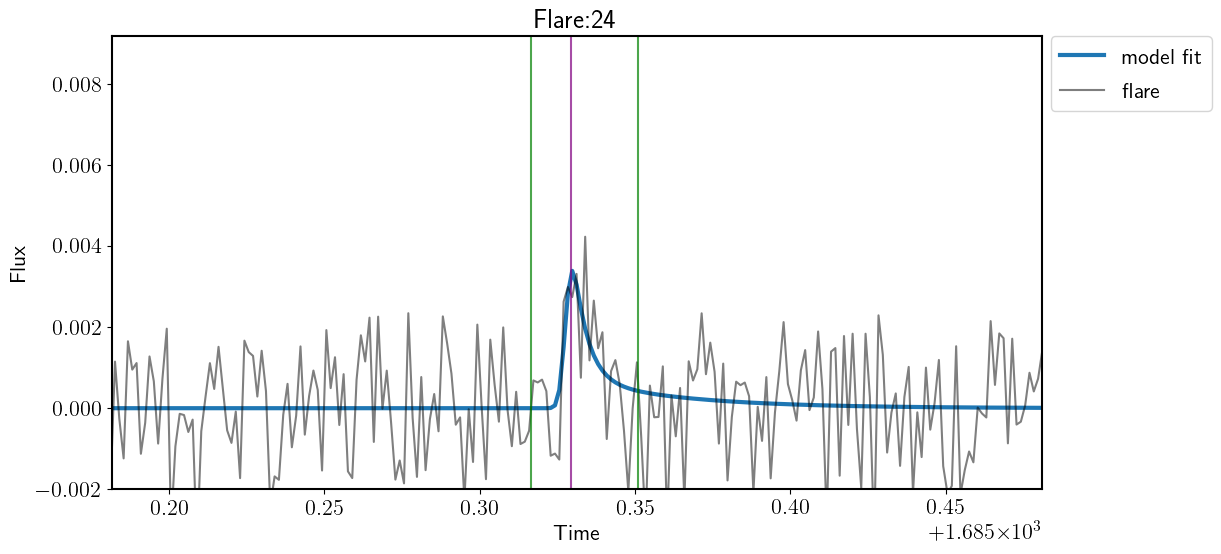

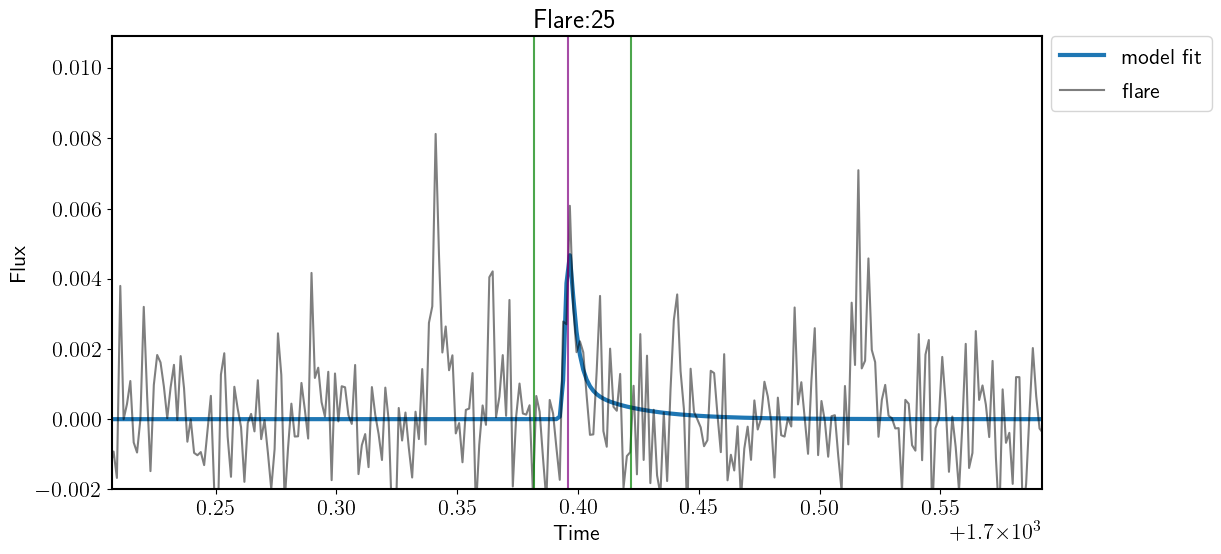

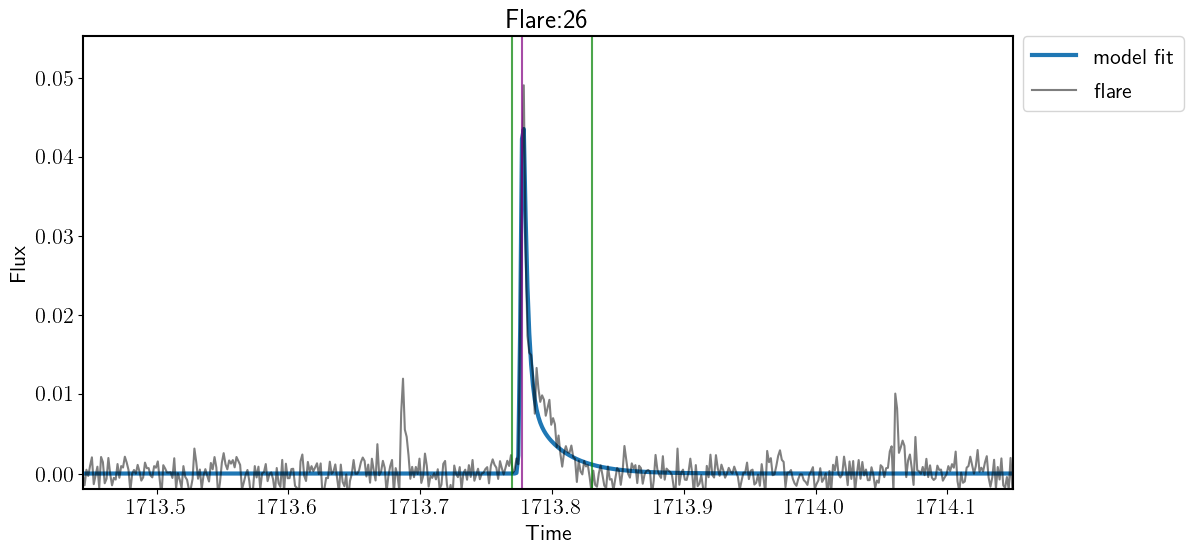

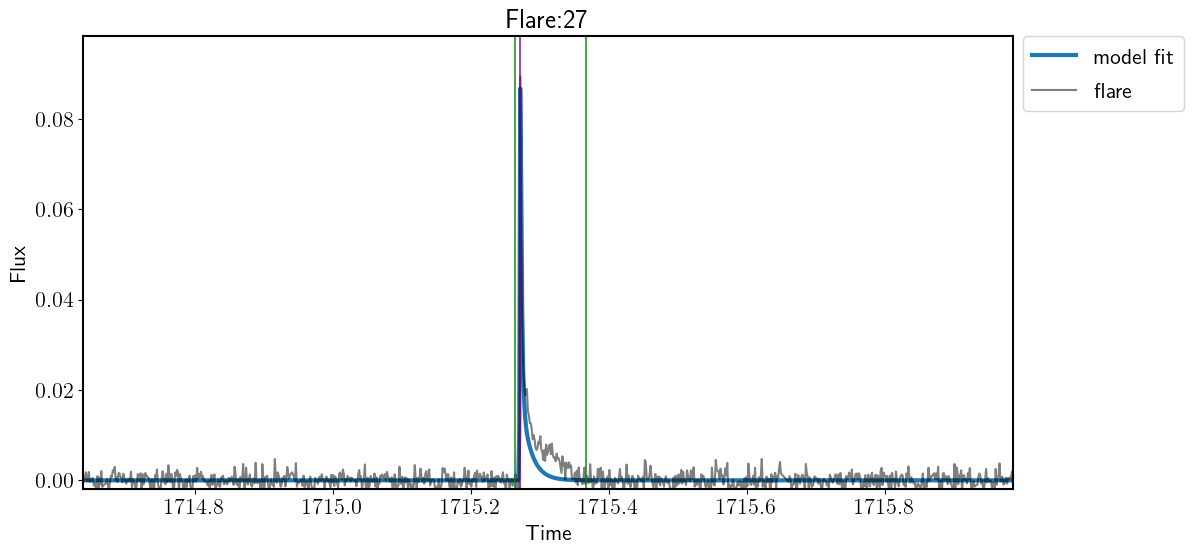

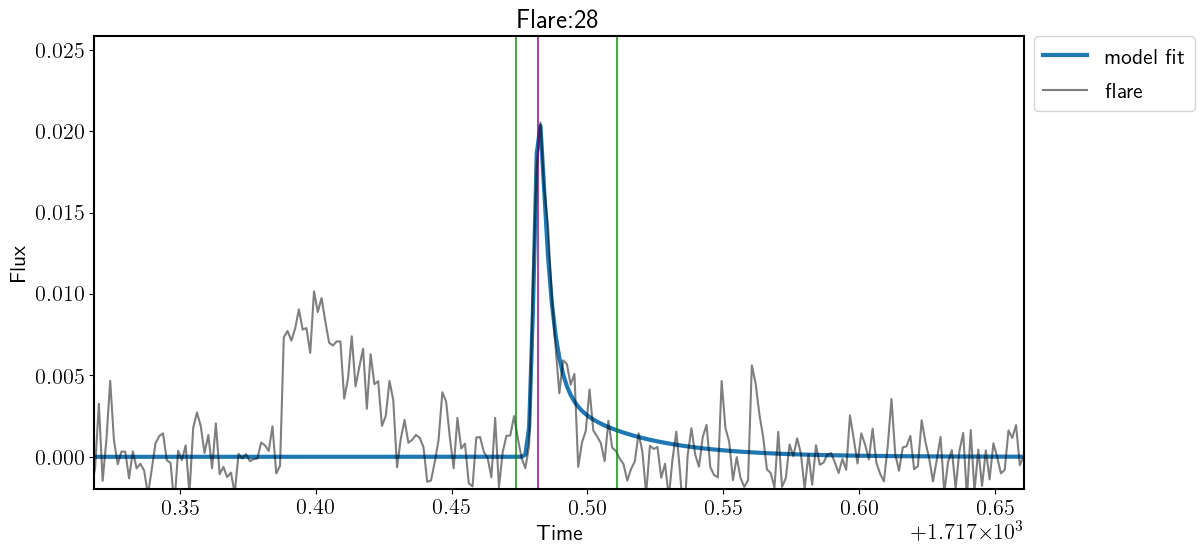

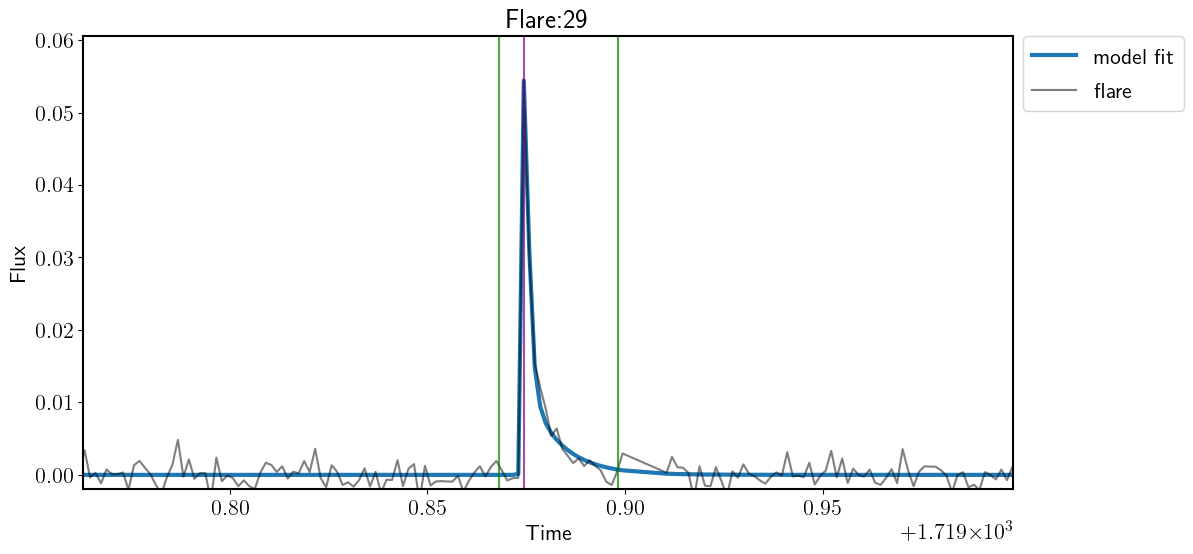

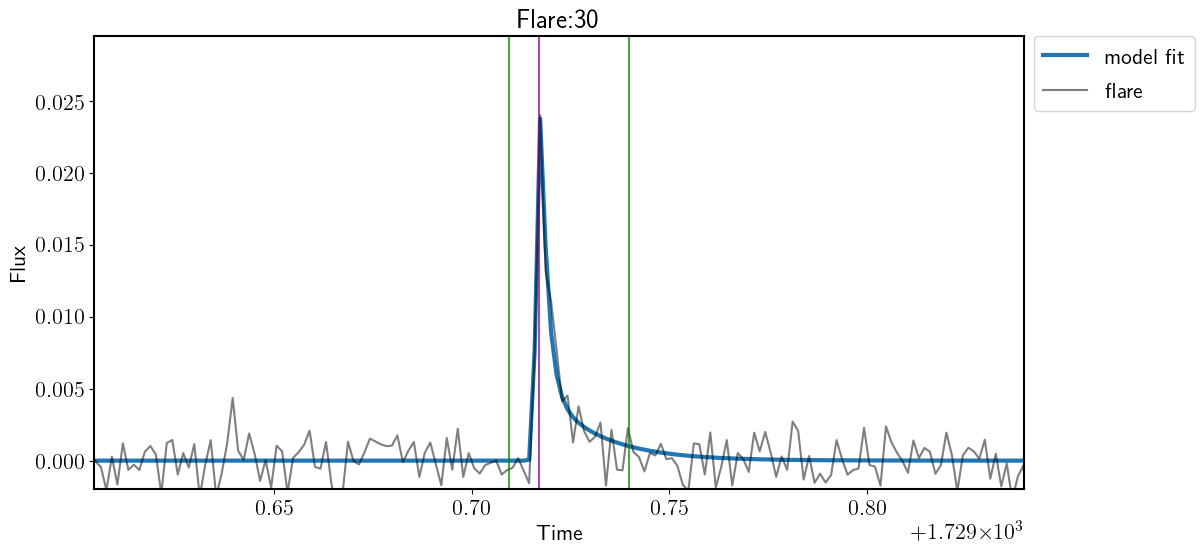

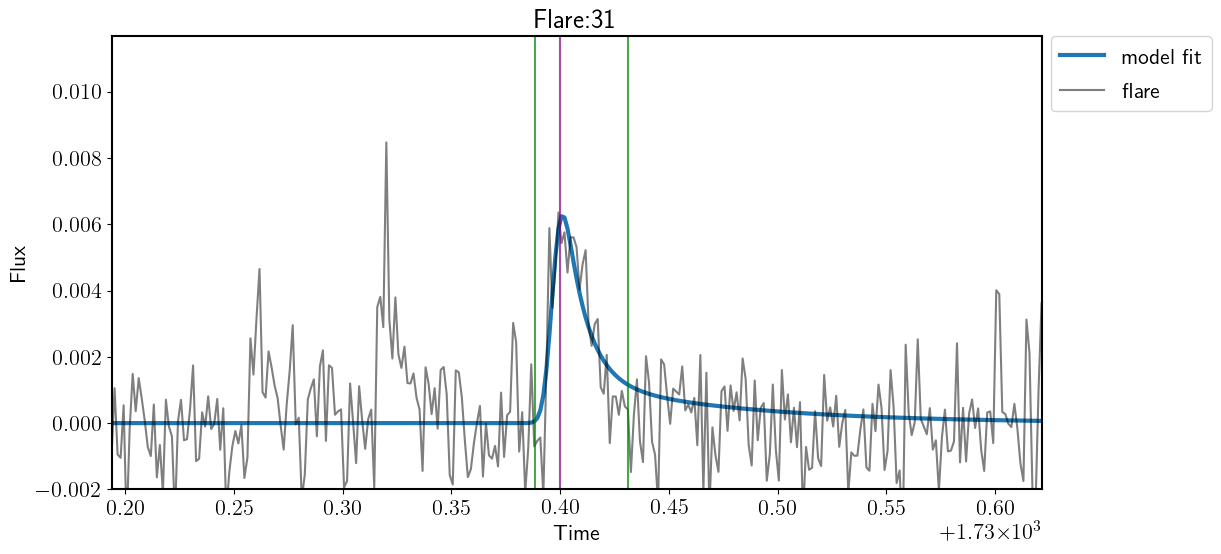

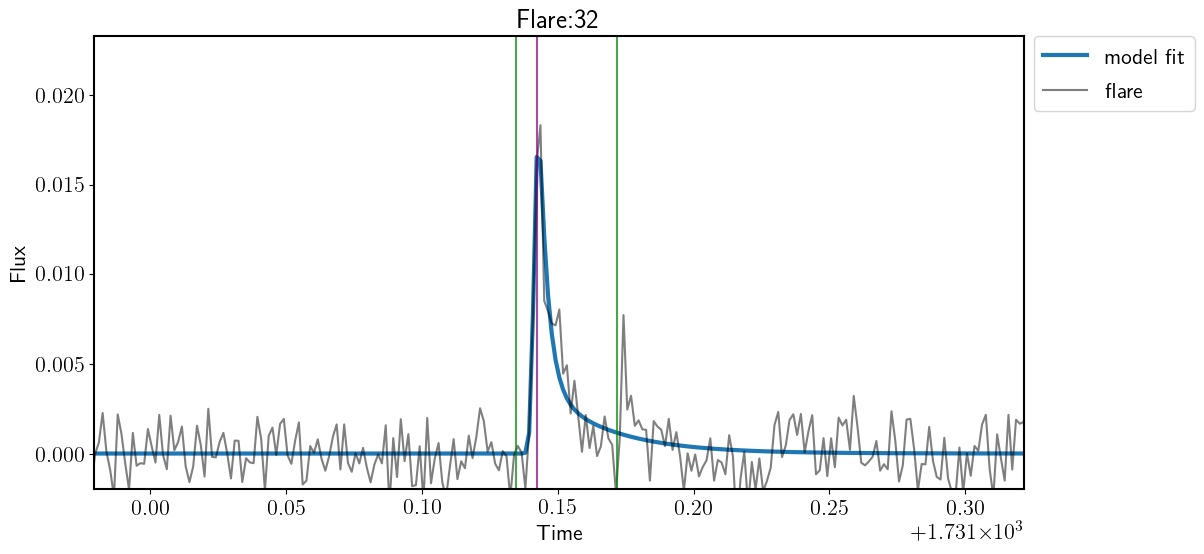

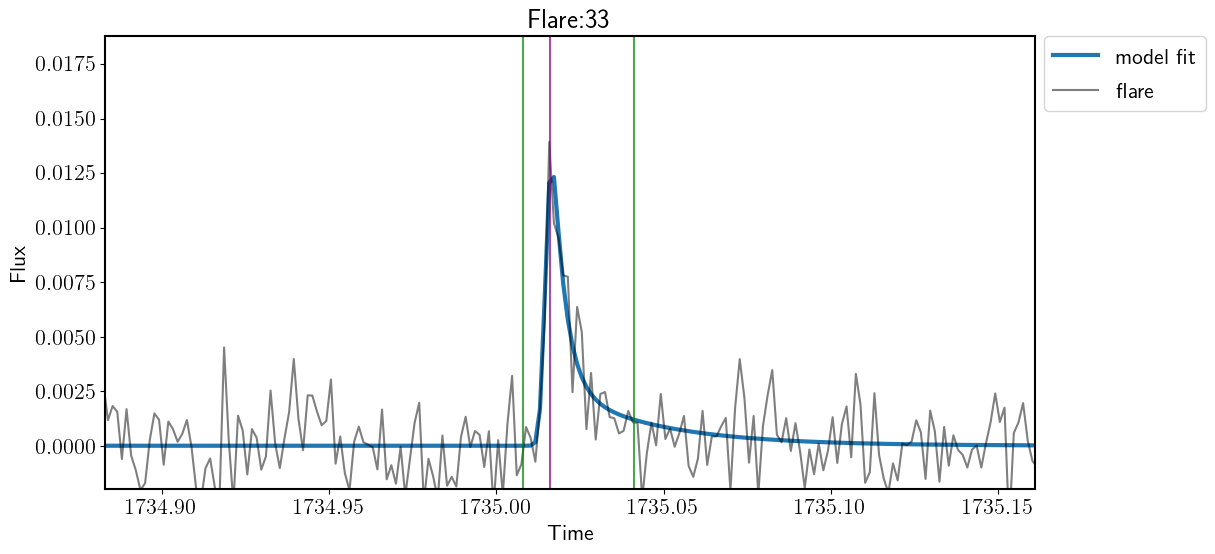

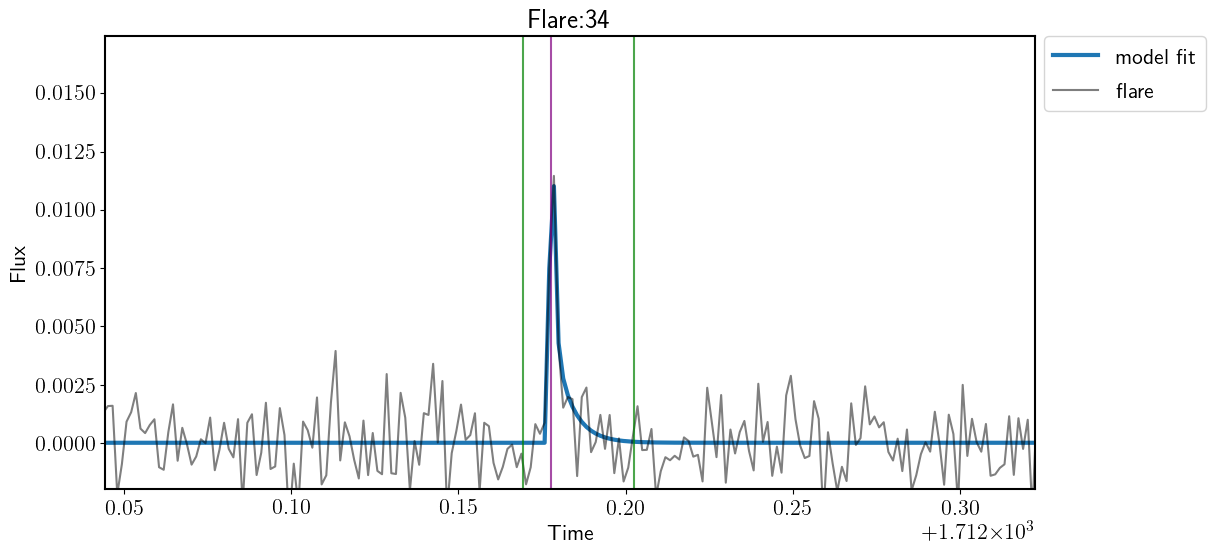

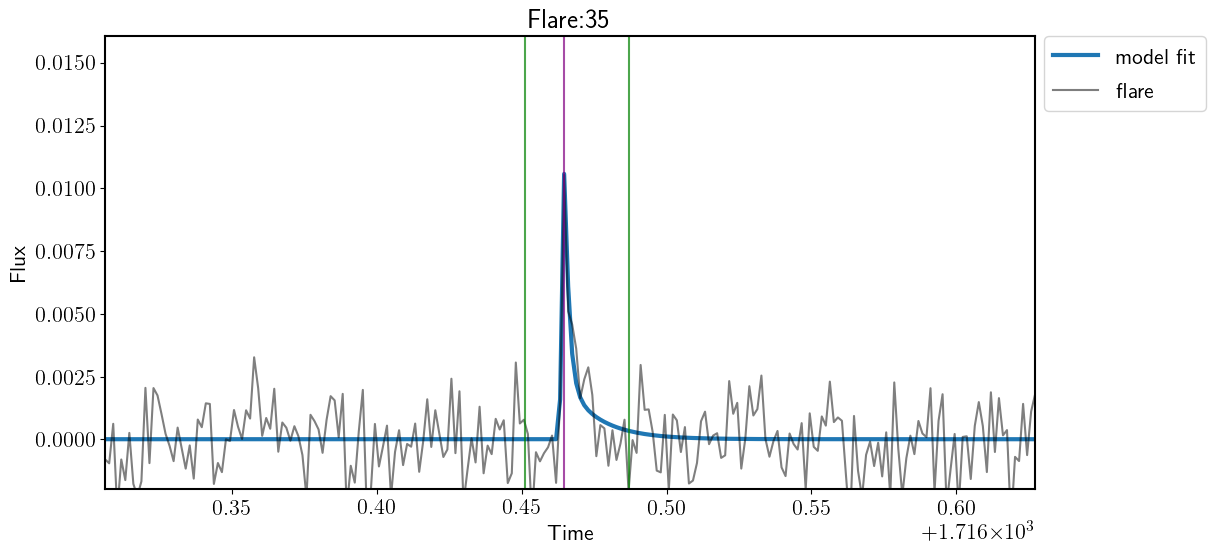

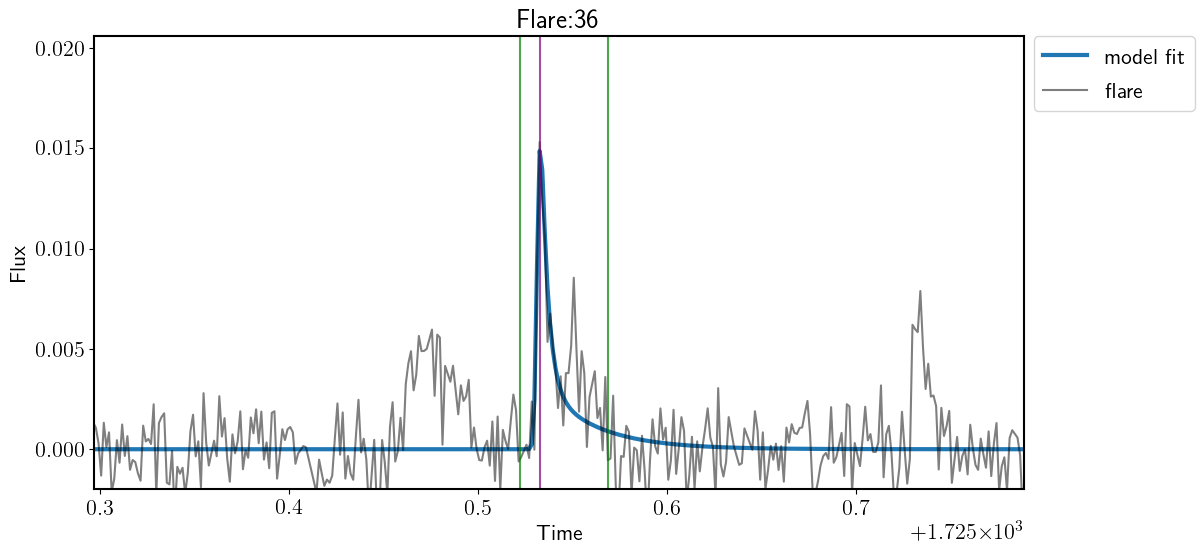

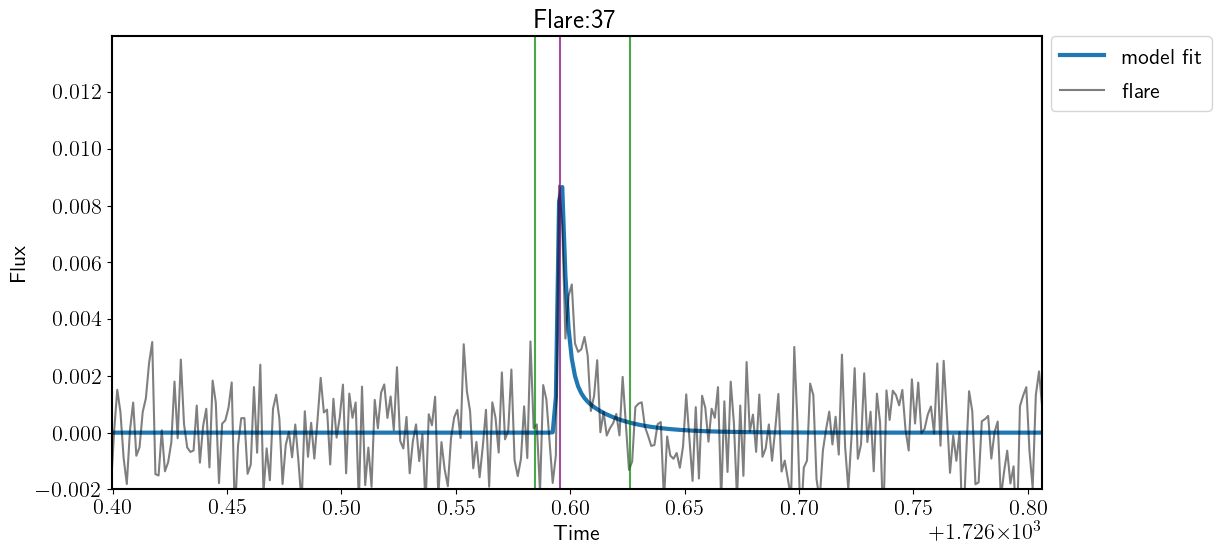

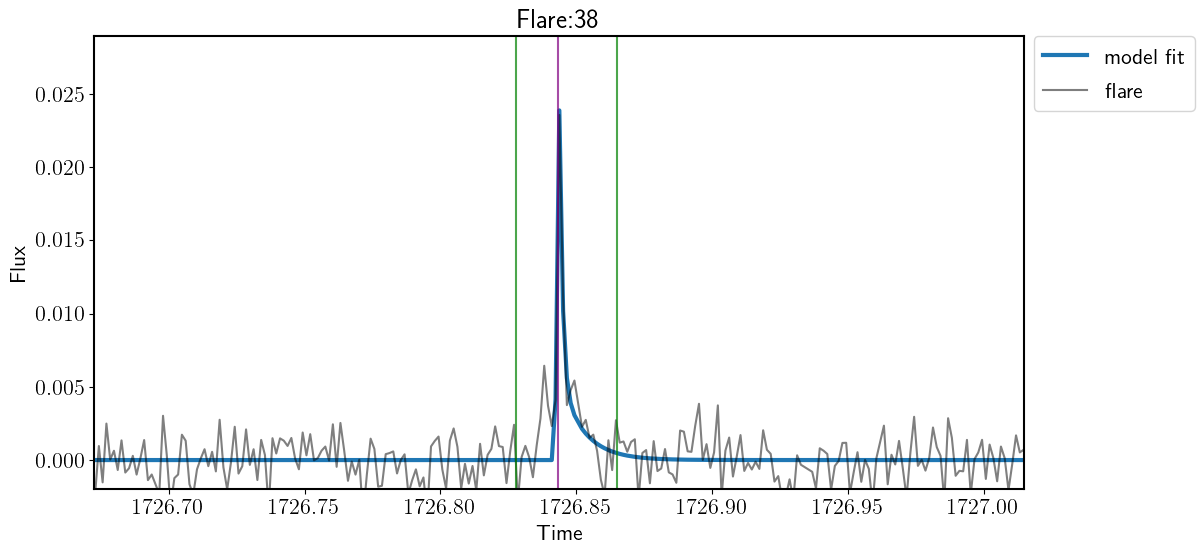

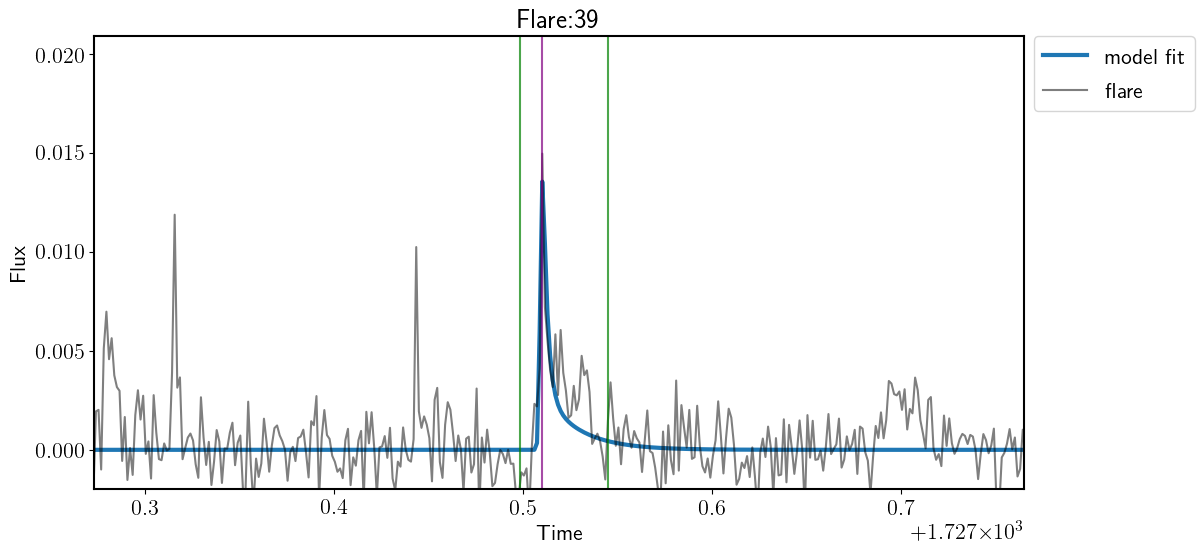

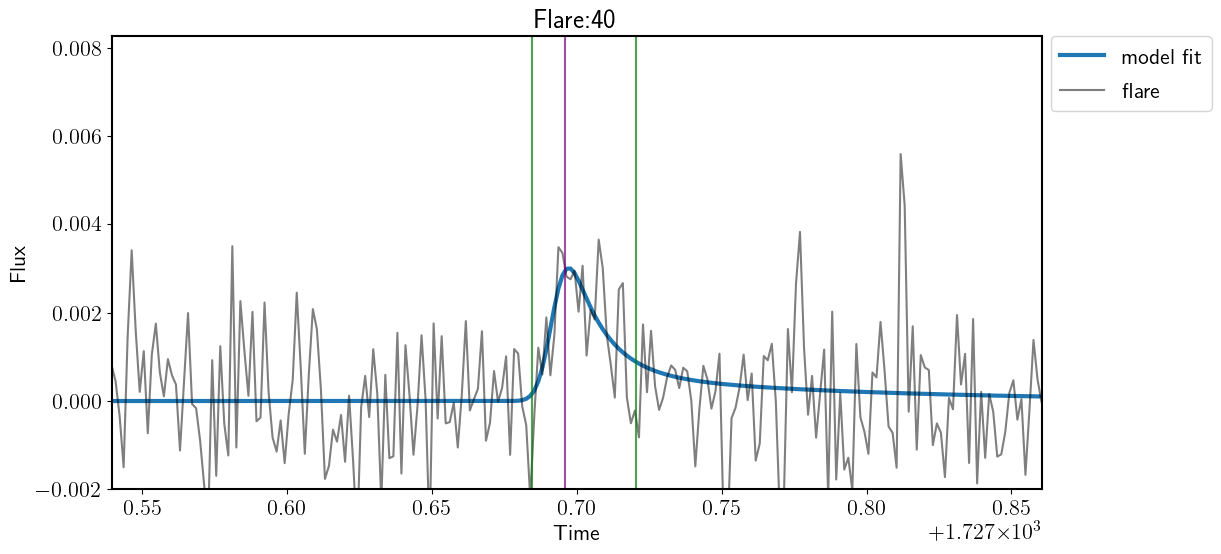

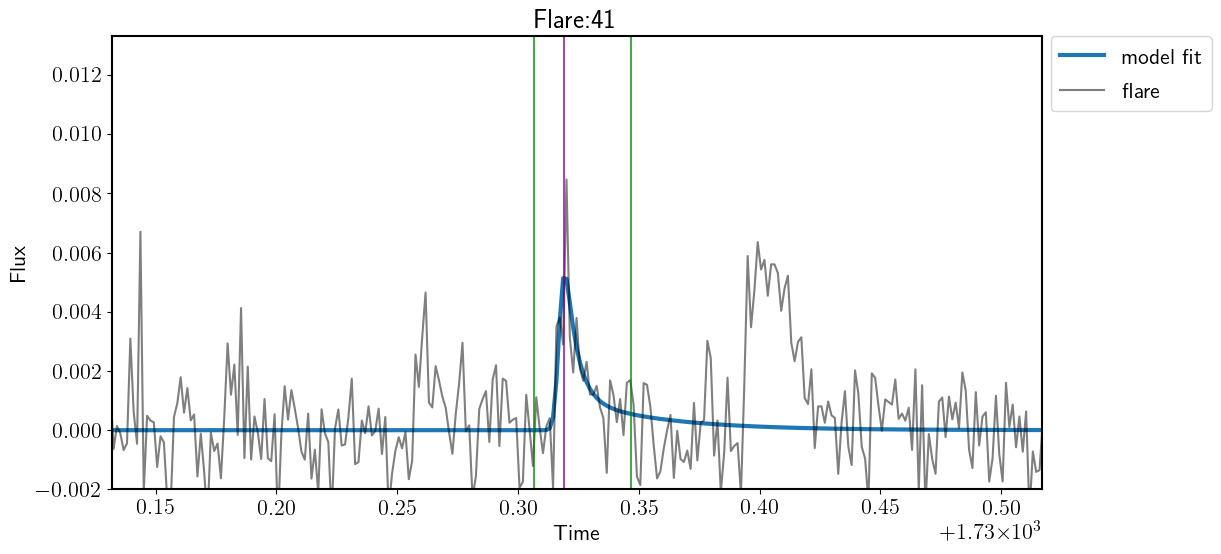

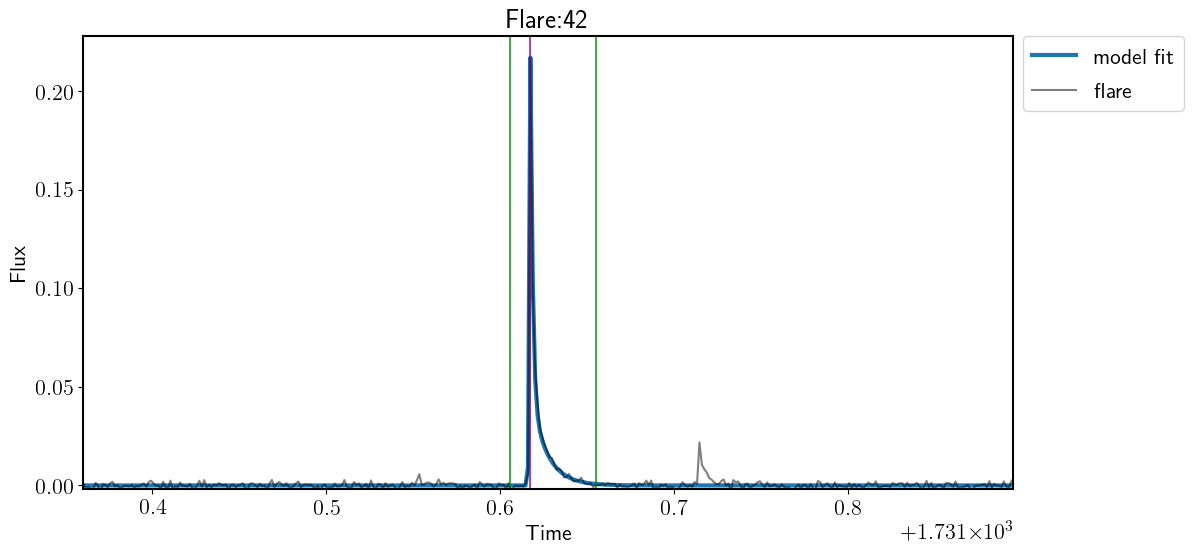

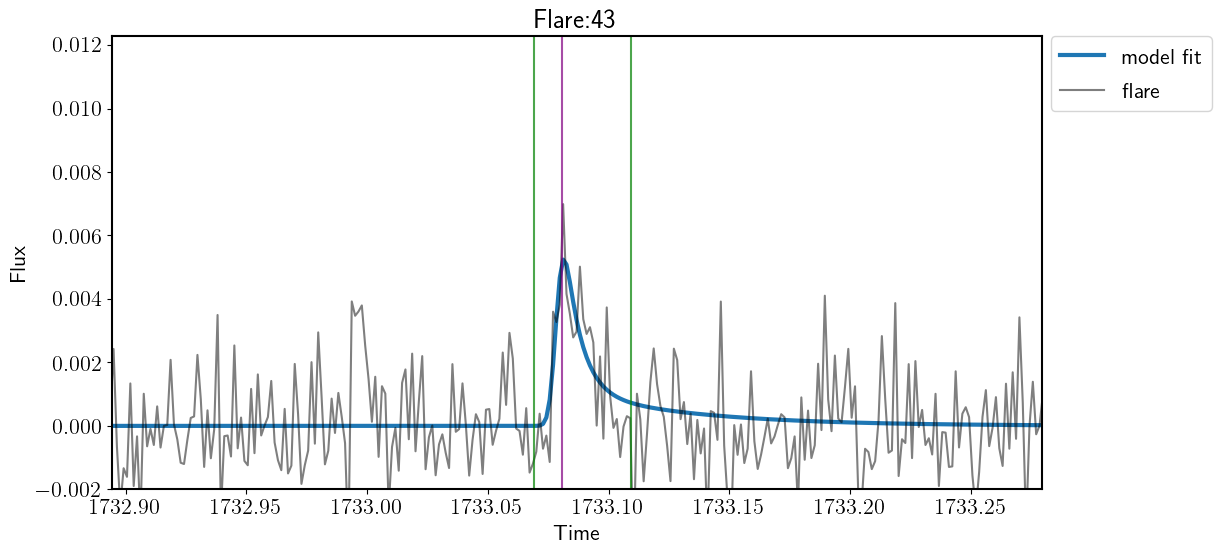

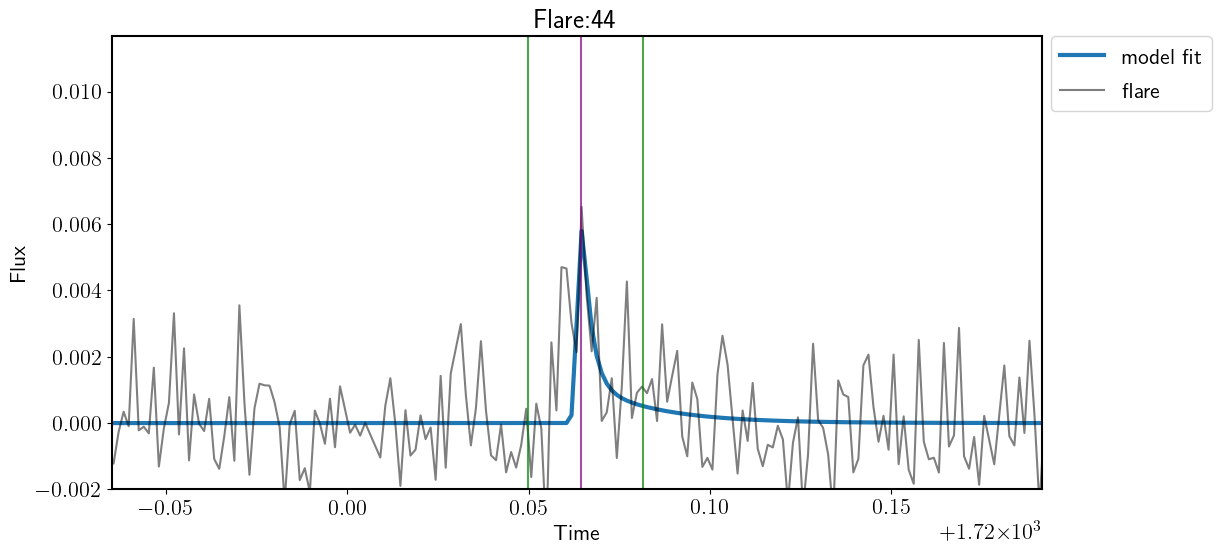

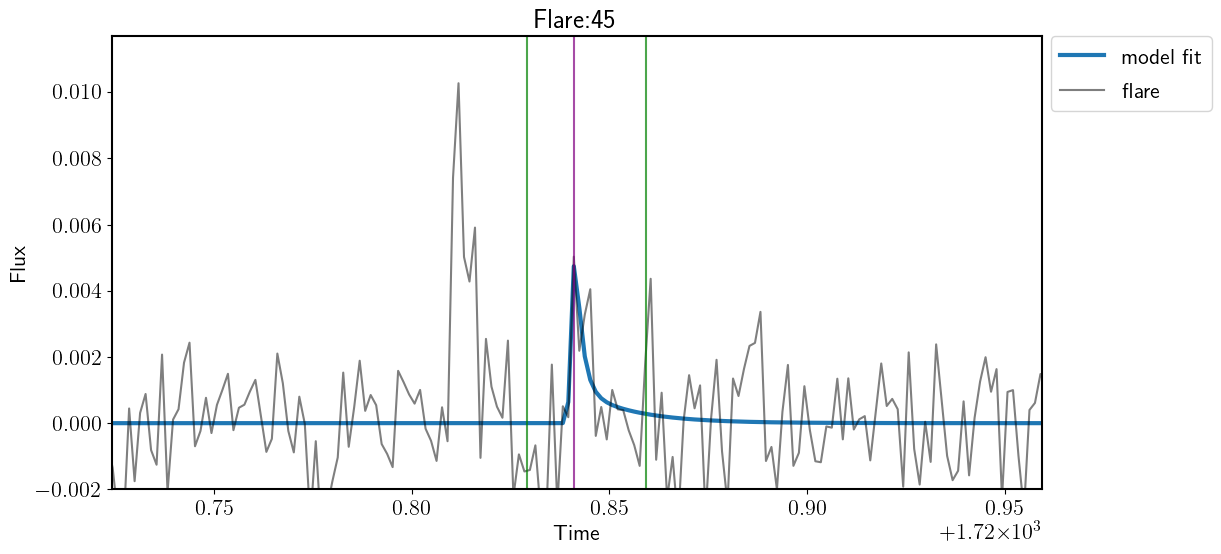

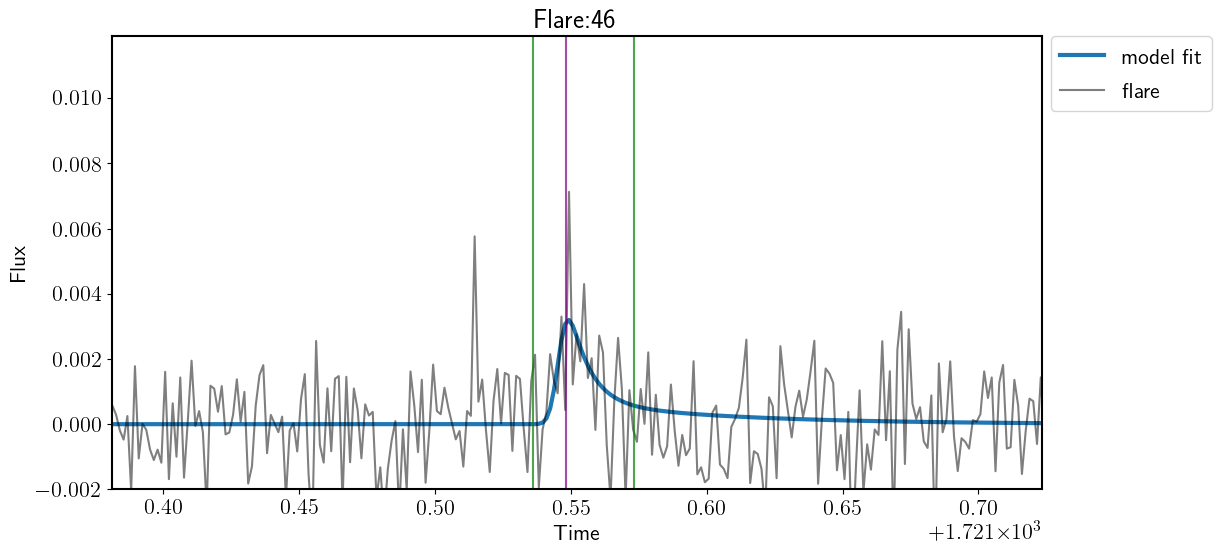

In [49]:
for i in range(0,len(classical_flares)):
    plt.figure(figsize=[12,6])
    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)
    i_temp = np.where((df['time'].values <= classical_flares['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= classical_flares['t_start'].values[i]-0.005))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks2[i])/(fwhms2[i]) 
    temp_y_stack = ((detrended[i_temp])/(amps2[i]))
    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    plt.plot(df['time'],flare_model_v2(df['time'],tpeaks2[i],fwhms2[i],amps2[i]),color='C0',label='model fit',lw=3)

    plt.plot(df['time'],detrended,color='black',label='flare',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=classical_flares['t_start'].values[i]-0.005, color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=classical_flares['t_stop'].values[i]+0.01, color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=tpeaks2[i], color='purple', linestyle='-',alpha=0.7)

    plt.ylim(-.002,classical_flares['Flux_peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(classical_flares['t_start'].values[i]-.005*classical_flares['Flare_Duration'].values[i],classical_flares['t_stop'].values[i]+.005*classical_flares['Flare_Duration'].values[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    #plt.savefig('/Users/lupitatovar/local_flares/notebooks/flare_diagnostics2/'+'flare'+str(i)+'.png',bbox_inches='tight')
    #plt.close()

In [ ]:
len(classical_flares)

In [50]:
vet_flares=pd.read_csv('/Users/lupitatovar/local_flares/notebooks/tess_flare_diagnostics.csv',
                       names=["Flare_Number","Type","Notes"],skiprows=1)

#Key:                                     
#1 = classical
#2 =adjust start/stop
#3 = complex. 
#4=noise

In [238]:
len(vet_flares)

47

In [51]:
flag2 = pd.to_numeric(vet_flares["Type"].values, errors='coerce')

In [52]:
still_classical = len([i for i in flag2 if i == 1.])
print ("The number of remaining classical flares : " + str(still_classical)) 

toss = len([i for i in flag2 if i == 3.]) 
print ("The number flares tossed out : " + str(toss)) 

The number of remaining classical flares : 25
The number flares tossed out : 18


In [53]:
toss_flares = vet_flares[vet_flares["Type"].values == 3.]
still_classic_flares = vet_flares[vet_flares["Type"].values == 1.]
print(len(still_classic_flares))

25


In [54]:
classical_flares['Index'] = np.arange(len(classical_flares))

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
cross_match = pd.merge(left=classical_flares, right=still_classic_flares, left_on='Index', right_on='Flare_Number')

In [239]:
len(cross_match)

25

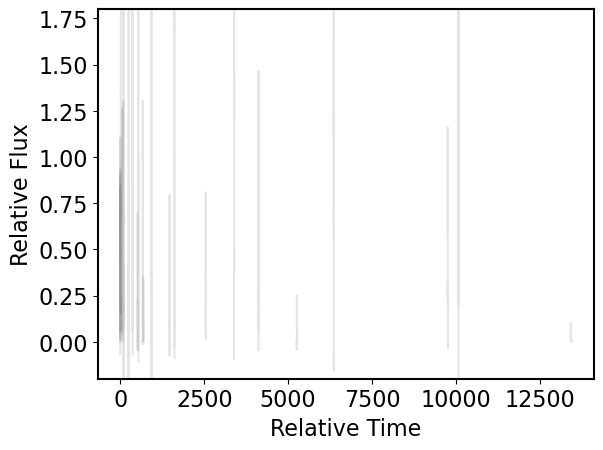

In [241]:
# stacking classical vetted tess flares with D14 technique

tess_stack_time=np.array([])
tess_stack_flux=np.array([])
tess_stack_yerr = np.array([])
tess_stack_gperr = np.array([])
xlim1=-5
xlim2=20
ylim1= -0.2
ylim2= 1.8

#plt.figure( figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(cross_match)):
 
    
    #coeffs array already has these values: tpeak(time_max), fwhm(t_half), ampl(peak)
    # defining the variable to plot
    final_temp = np.where((df['time'].values <= cross_match['t_stop'].values[i]) & 
                    (df['time'].values >= cross_match['t_start'].values[i]))[0]
    
    temp_x_stack3 = (df['time'].values[final_temp] - tpeaks2[i])/(fwhms2[i])
    temp_y_stack3 = ((detrended[final_temp])/(amps2[i]))
    plt.plot(temp_x_stack3,temp_y_stack3,color='black',alpha=0.1)


    #Time Arrays
    nxs3 = np.where((temp_x_stack3 <= xlim2) & (temp_x_stack3>=xlim1)& (temp_y_stack3 <= ylim2) & (temp_y_stack3>=ylim1))[0]
    tess_stack_time = np.append(tess_stack_time,temp_x_stack3[nxs3])
        
    #Flux Arrays
    tess_stack_flux = np.append(tess_stack_flux,temp_y_stack3[nxs3])
        
    #Flux Errors
    flux_err3 = df['df_flux_err'].values/tpeaks2[i] 
    tess_stack_yerr = np.append(tess_stack_yerr,flux_err3[nxs3])
        
    #GP Standard Deviation
    st_dev3 = df['std'].values/tpeaks2[i]
    tess_stack_gperr = np.append(tess_stack_gperr,st_dev3[nxs3])
                  
   
    
    ########## PLOTTING ################
    #plt.plot(temp_x_stack,temp_y_stack,color='k',alpha=0.01)

    #the plot below is in cumulative distribution space
    #plt.plot(temp_x_stack,np.cumsum(temp_y_stack)/np.sum(temp_y_stack),color='k')

   

    #Setting Titles
    #axs[0].set_title('Stacked Flares')
    #axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    plt.xlabel("Relative Time")
    plt.ylabel("Relative Flux")    
    #axs[1].set_ylabel("Cummulative Flux")
    #axs[1].set_xlabel("Relative Time")

    #Axes limits
    #plt.xlim(-1,20)
    plt.ylim(-0.2,1.8)
    
    
#plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
    

#plt.savefig('')


In [56]:
# re-fitting the now vetted subset of flares with new curvefit procedure

tpeaks2_vet = [] 
fwhms2_vet = [] 
amps2_vet = []

tpeaks_err2_vet = []
fwhms_err2_vet = []
amps_err2_vet = []

#t,tpeak, fwhm, ampl
for i in range (0,len(cross_match)):

    #Defining times of each flare event
    vet_temp = np.where((df['time'].values <= (cross_match['t_stop'].values[i]+0.01)) & 
                    (df['time'].values >= (cross_match['t_start'].values[i]-0.005)))[0]
    
    peak_flujo_vet = cross_match['t_stop'].values - cross_match['t_start'].values
    
    #arrays to feed to curvefit
    x_fit2_vet = df['time'].values[vet_temp]
    y_fit2_vet = detrended[vet_temp]
    
    #initial values
    init_vals_vet= [cross_match['t_peak'].values[i],  peak_flujo_vet[i]/4,cross_match['Flux_peak'].values[i]]
    
    #running curvefit
    best_vals_vet, covar_vet = curve_fit(flare_model_v2, x_fit2_vet, y_fit2_vet, p0=init_vals_vet, maxfev=10000, sigma= error1[vet_temp],
                                  bounds=[[min(x_fit2_vet),0,0],[max(x_fit2_vet),peak_flujo_vet[i],3*max(y_fit2_vet)]])
    #print('best_vals: {}'.format(best_vals2))
    
    err_vet = np.sqrt(np.diag(covar_vet))
    
    ############# Saving Output Arrays ################
    tpeaks2_vet = np.append(tpeaks2_vet,best_vals_vet[0])
    fwhms2_vet = np.append(fwhms2_vet,best_vals_vet[1])
    amps2_vet = np.append(amps2_vet,best_vals_vet[2])
    
    tpeaks_err2_vet = np.append(tpeaks_err2_vet,err_vet[0])
    fwhms_err2_vet = np.append(fwhms_err2_vet,err_vet[1])
    amps_err2_vet = np.append(amps_err2_vet,err_vet[2])


In [ ]:
#saving the arrays to a file
#dict_i = {'time':time_stack_fits,'flux':flux_stack_fits , 'flux_err':stack_y_err , 'gp_st_dev':stack_gp_st_dev } 
#tess_stacked_fit_flares = pd.DataFrame(data=dict_i) 
#tess_stacked_fit_flares.to_csv(r'tess_stacked_fit_flare_vals.csv',header=True,index=True)

In [ ]:
#get rid of -2 in the plots (stack should be centered at 0 by construction, mcmc jackman2 func should have +2)

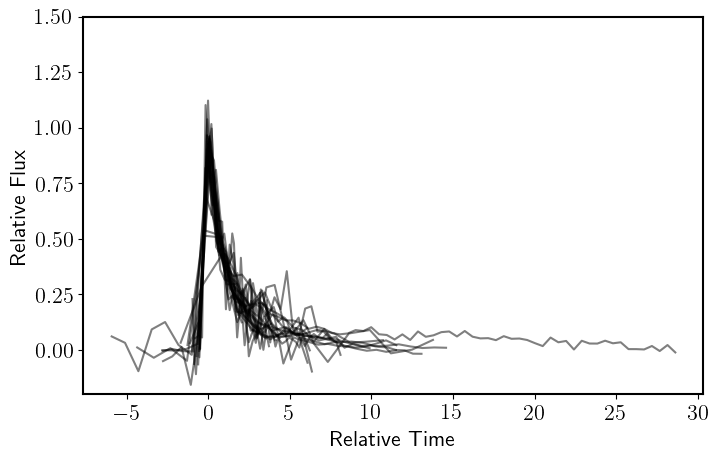

In [57]:
time_stack_fits=np.array([])
flux_stack_fits=np.array([])
stack_y_err = np.array([])
stack_gp_st_dev = np.array([])
xlim1=-5
xlim2=20
ylim1= -0.2
ylim2= 1.8


#plt.figure( figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(0,len(cross_match)):

    #coeffs array already has these values: tpeak(time_max), fwhm(t_half), ampl(peak)
    # defining the variable to plot
    i_t2 = np.where((df['time'].values <= cross_match['t_stop'].values[i]) & 
                    (df['time'].values >= cross_match['t_start'].values[i]))[0]
    
    temp_x_ = (df['time'].values[i_t2] - tpeaks2_vet[i])/(fwhms2_vet[i])
    temp_y_ = ((detrended[i_t2])/(amps2_vet[i]))
    plt.plot(temp_x_,temp_y_,color='black',alpha=0.5)


    #Time Arrays
    nxs = np.where((temp_x_ <= xlim2) & (temp_x_>=xlim1)& (temp_y_ <= ylim2) & (temp_y_>=ylim1))[0]
    time_stack_fits = np.append(time_stack_fits,temp_x_[nxs])
        
    #Flux Arrays
    flux_stack_fits = np.append(flux_stack_fits,temp_y_[nxs])
        
    #Flux Errors
    new_flux_err = df['df_flux_err'].values/tpeaks2_vet[i] 
    stack_y_err = np.append(stack_y_err,new_flux_err[nxs])
        
    #GP Standard Deviation
    new_st_dev = df['std'].values/tpeaks2_vet[i]
    stack_gp_st_dev = np.append(stack_gp_st_dev,new_st_dev[nxs])
                  
   
    
    ########## PLOTTING ################
    #plt.plot(temp_x_stack,temp_y_stack,color='k',alpha=0.01)

    #the plot below is in cumulative distribution space
    #plt.plot(temp_x_stack,np.cumsum(temp_y_stack)/np.sum(temp_y_stack),color='k')

   

    #Setting Titles
    #axs[0].set_title('Stacked Flares')
    #axs[1].set_title('Cumulative Distribution')
    

    #Axes labels
    plt.xlabel("Relative Time")
    plt.ylabel("Relative Flux")    
    #axs[1].set_ylabel("Cummulative Flux")
    #axs[1].set_xlabel("Relative Time")

    #Axes limits
    #plt.xlim(-1,20)
    plt.ylim(-0.2,1.5)
    
    
#plt.plot(x_new,aflare1(x_new,0,1,1),color='red',label='Jims Model')        
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)    
    

#plt.savefig('')


In [161]:
#saving the arrays to a file
#dict_i = {'time':time_stack_fits,'flux':flux_stack_fits , 'flux_err':stack_y_err , 'gp_st_dev':stack_gp_st_dev } 
#tess_stacked_fit_flares = pd.DataFrame(data=dict_i) 
#tess_stacked_fit_flares.to_csv(r'tess_stacked_fit_flare_vals.csv',header=True,index=True)

In [58]:
fit_flare_vals=pd.read_csv('tess_stacked_fit_flare_vals.csv')

Text(0, 0.5, 'Relative Flux')

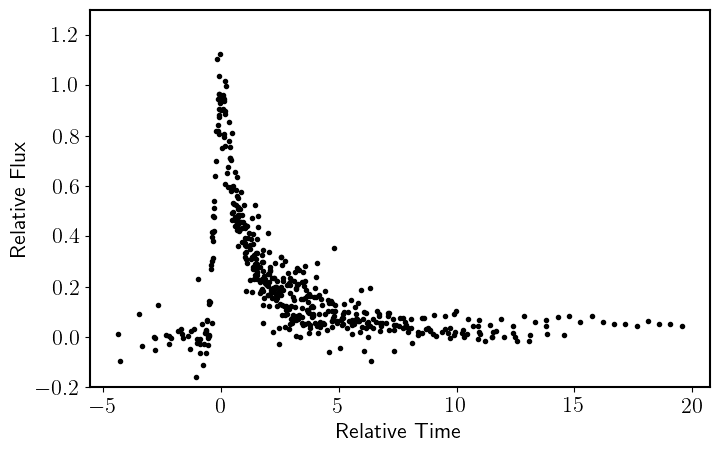

In [59]:
fit_time = fit_flare_vals['time'].values
fit_flux = fit_flare_vals['flux'].values
fit_flux_err = fit_flare_vals['flux_err'].values
fit_gp_err = fit_flare_vals['gp_st_dev'].values

fit_both_errors = np.sqrt( (fit_flux_err)**2 + (fit_gp_err)**2 )

fit_sort = np.argsort(fit_time)
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],s=35,marker='.',color='k')
plt.ylim(-0.2,1.3)
#plt.xlim(-0.5,10)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")

(-0.2, 1.3)

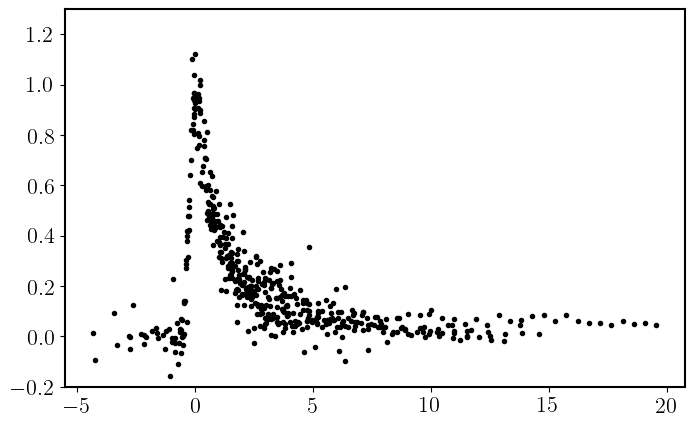

In [60]:
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],s=35,marker='.',color='k')
plt.ylim(-0.2,1.3)
#plt.xlim(15,20)

In [ ]:
len(fit_flux)

MCMC Fit

In [61]:
import emcee
from IPython.display import display, Math
import corner

In [134]:
A_i,B_i,C_i,D1_i,D2_i,f1_i = [3.46452433, 1.74147744, 0.21642749, 0.22529022, 1.39565109, 0.21624606]
#[2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386]
#2.93019203, 1.78279154, 0.3113989, 0.21181818, 1.63976688, 0.13602386 numbers from model V0 run
#[3.40885267,  3.74774459, -0.21710296,  0.16109176,  1.35048373,  0.18575378]


def jackman2(t_in,theta2):
    t= t_in +2
    A,B,C,D1,D2,f1=theta2
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    double_exp = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t/C)))) 
                                             + (f2 * np.exp((D2*(B-t)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t/C)))))
    erf_bound = 0.5*(special.erf((t-0.2)*100) + 1)
    return double_exp*erf_bound


def lnlike2(theta2, time, flux, both_errors):
    debug = True
    A,B,C,D1,D2,f1 = theta2
    jackman_model = jackman2(time,theta2)
    #erf_bound = 0.5*(special.erf((time-0.2)*100) + 1)
    #model = jackman_model*erf_bound
    # the dreaded negative-number cliff!
    #if (np.nanmin(model) >= 0) and ((jackman2(np.array([-1000.]),theta2)* (0.5*(special.erf((-1000-0.2)*100) + 1))) >= 0):
    if (np.nanmin(jackman_model) < 0):    
        if degug:
            print('DEBUG: model>0 error')
        return -np.inf
    
    if (jackman2(np.array([-1000.]),theta2)* (0.5*(special.erf((-1000-0.2)*100) + 1))) < 0:
        if degug:
            print('DEBUG: -1000 error')    
        return -np.inf
        
    lnlike2 = -0.5*(np.sum(((flux-jackman_model)/both_errors)**2))
        #return lnlike2
    return lnlike2

def lnprior2(theta2):
    A,B,C,D1,D2,f1 = theta2
    debug = False
    if (D1 > 0.) and (0. <= f1 <= 1): #D1<0 | f1>1 #switch to and
        if debug:
            print('DEBUG:boundary')
        return 0.0
    #if not np.sum(np.isfinite(theta2)):
        #return -np.inf
    return -np.inf


def lnprob2(theta2, time, flux, both_errors):
    lp2 = lnprior2(theta2)
    debug = False
    try:
        # put the model<0 check in lnlike2!
        ll2 = lnlike2(theta2, time, flux, both_errors)
        output = lp2 + ll2
        if np.any(np.isnan(output)):
            return -np.inf
        return output
    except:
        if debug:
            print ('Debug: ambiguous fail')
        return -np.inf

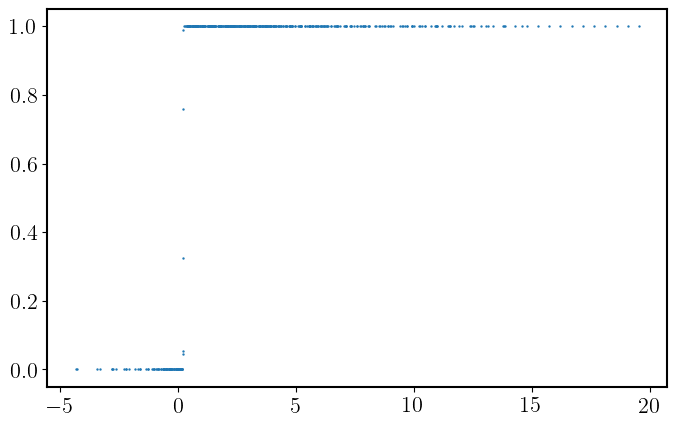

In [63]:
plt.scatter(fit_time, (0.5*(special.erf((fit_time-0.2)*100) + 1)),s=0.5)

In [64]:
print(lnprob2((A_i,B_i,C_i,D1_i,D2_i,f1_i),fit_time,fit_flux,fit_both_errors))
print(lnprob2((np.median(flat_samples2,axis=0)),fit_time,fit_flux,fit_both_errors))


plt.plot(fit_time[fit_sort],jackman2(fit_time,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[fit_sort],label='Jackman_guess',color='purple')
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],s=30,marker='.',color='grey')
plt.plot(fit_time[fit_sort],jackman2(fit_time,(np.median(flat_samples2,axis=0)))[fit_sort],label='This work',color='orange',lw=3)
plt.scatter(fit_time, (0.5*(special.erf((fit_time-0.2)*100) + 1)),s=0.5)


-2252756967529.883


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  


NameError: name 'flat_samples2' is not defined

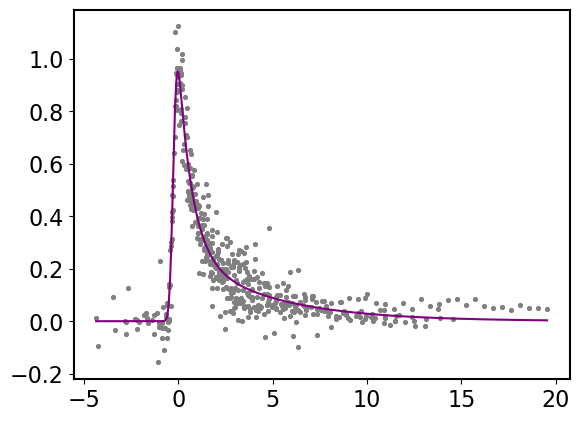

In [135]:
plt.plot(fit_time[fit_sort],jackman2(fit_time,(A_i,B_i,C_i,D1_i,D2_i,f1_i))[fit_sort],label='Jackman_guess',color='purple')
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],s=30,marker='.',color='grey')

In [136]:
initial2 = np.array([A_i,B_i,C_i,D1_i,D2_i,f1_i])
nwalkers2= 256 
ndim2=len(initial2)


pos2 = [np.array(initial2) + 1e-4 *np.random.rand(ndim2) for i in range(nwalkers2)]

In [137]:
#edit time and flux variables 
data = (fit_time[fit_sort],fit_flux[fit_sort],fit_both_errors[fit_sort])
#coords= np.random.randn(500, 6)
sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, lnprob2, args=data)#,backend=backend)


sampler2.run_mcmc(pos2, 30000, progress=True);

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
100%|██████████| 30000/30000 [22:57<00:00, 21.78it/s]


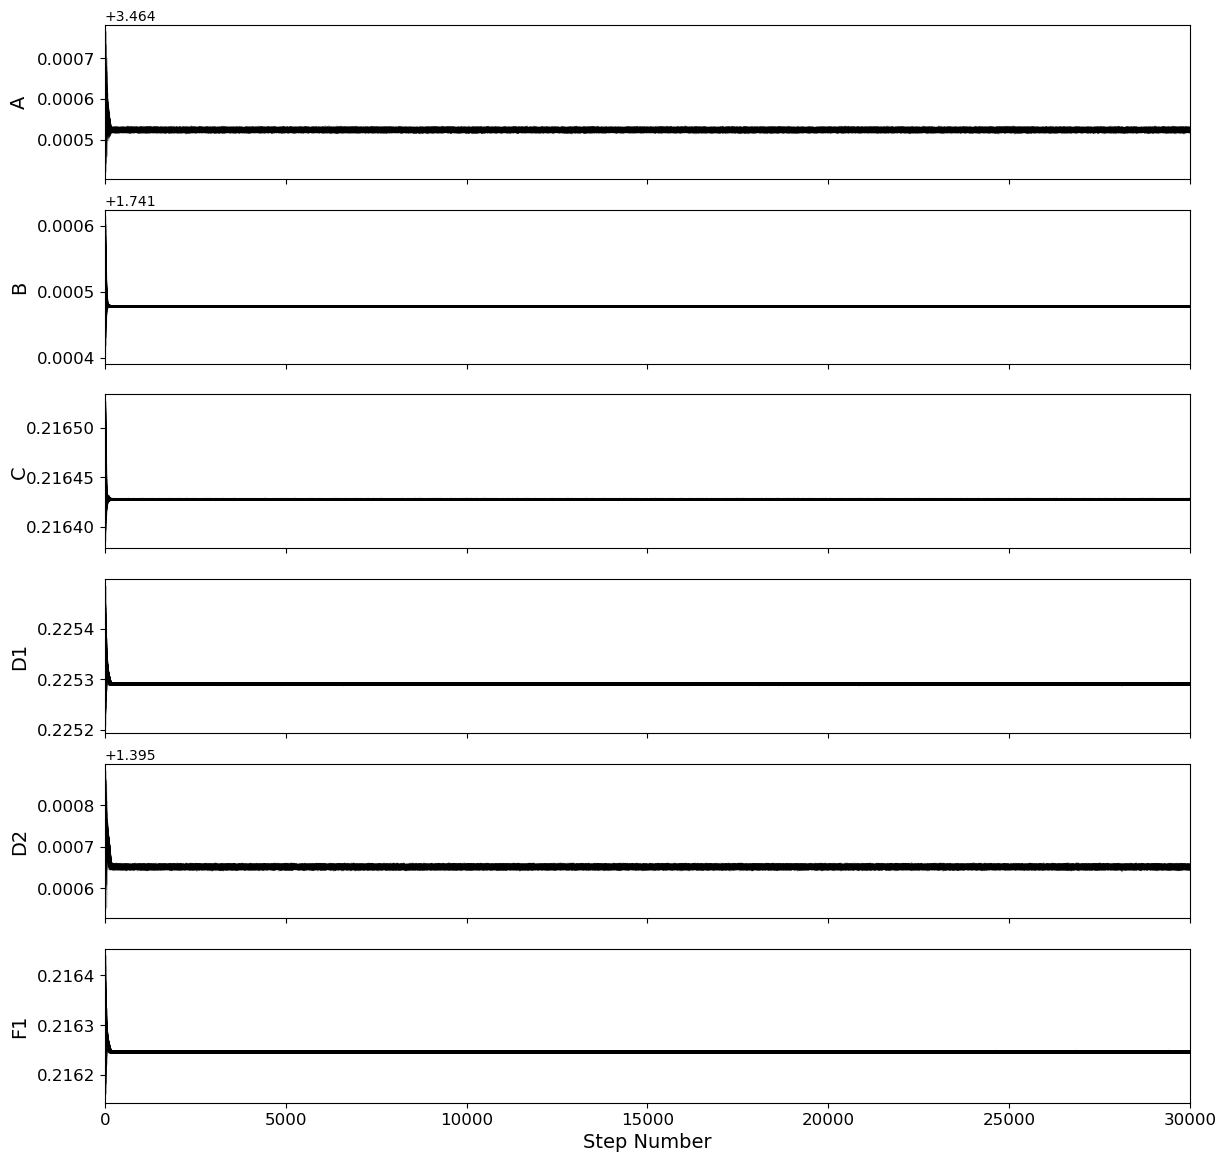

In [138]:
plt.style.use('default')
fig, axes = plt.subplots(6, figsize=(14, 14), sharex=True)
samples2 = sampler2.get_chain()
labels2 = ["A","B","C","D1","D2","F1"]
for i in range(ndim2):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels2[i],fontsize=14)
    ax.yaxis.set_label_coords(-.07,.5)
    ax.tick_params(axis='x',labelsize=12)
    ax.tick_params(axis='y',labelsize=12)


axes[-1].set_xlabel("Step Number",fontsize=14);

(1382400, 6)


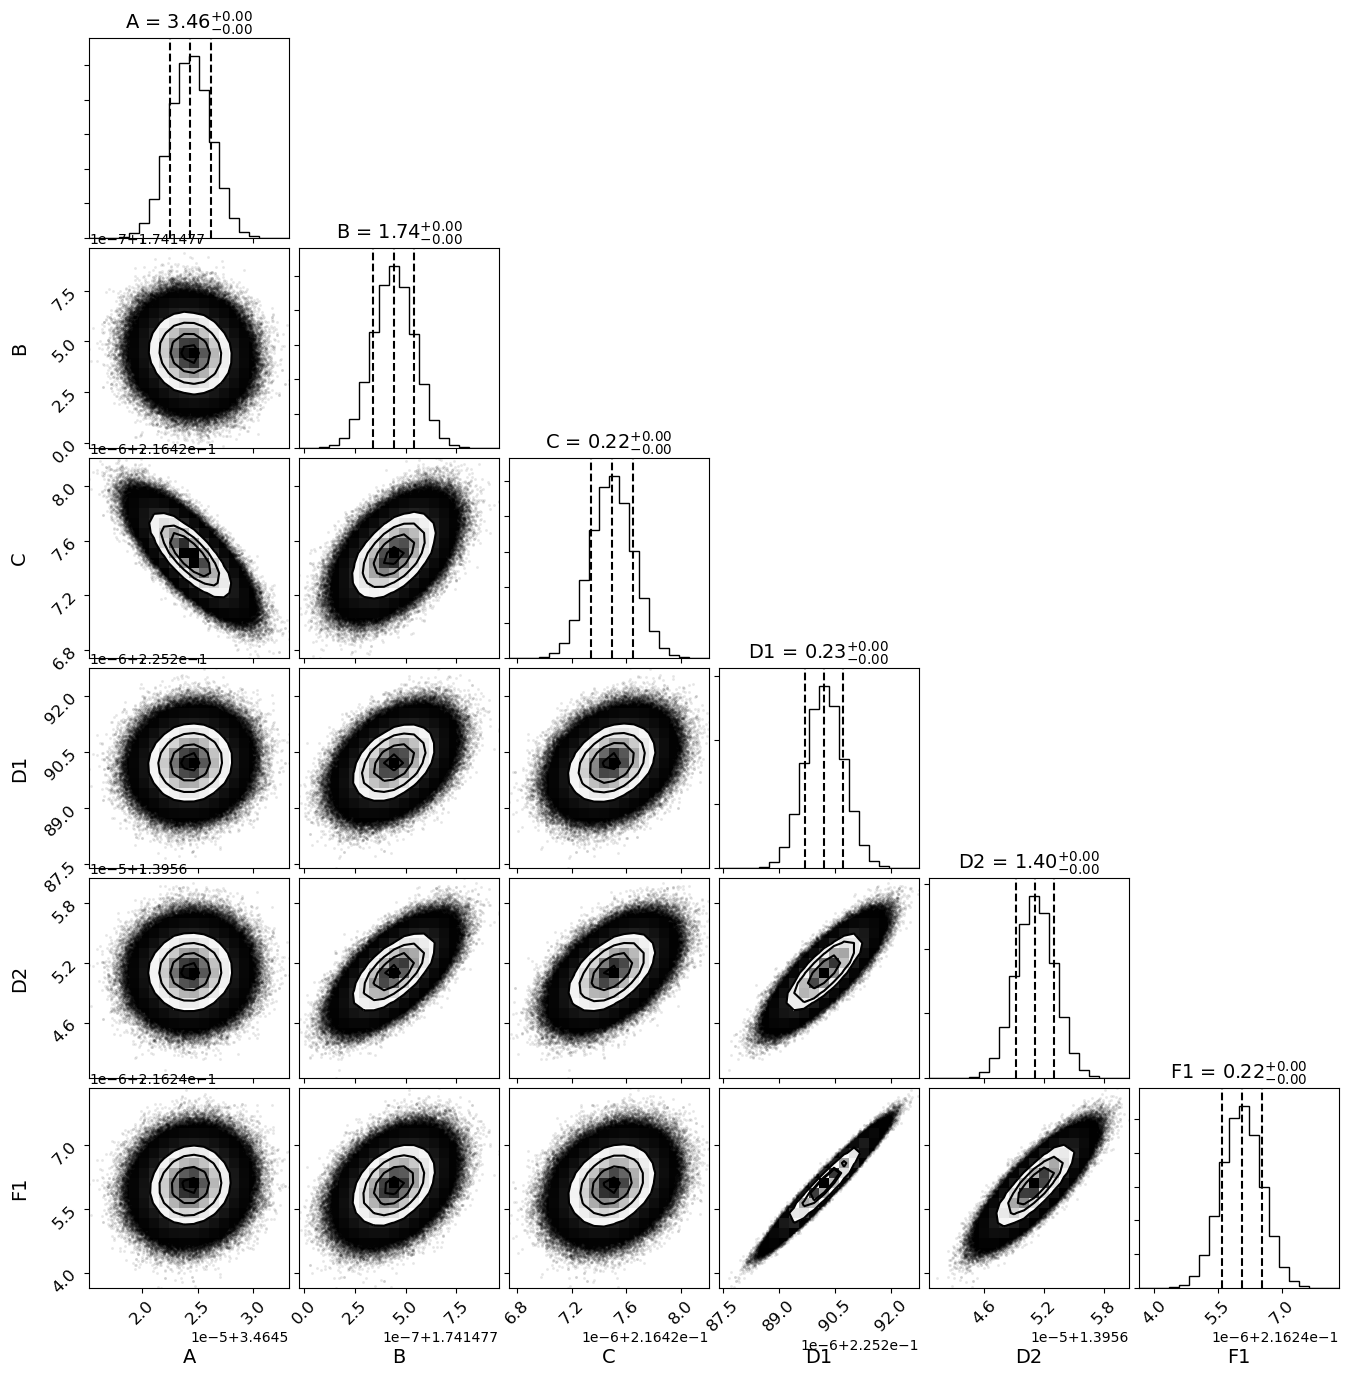

In [140]:

flat_samples2 = sampler2.get_chain(discard=3000, thin=5, flat=True)
#discard the first 10% for longer runs
print(flat_samples2.shape)

fig = corner.corner(
    flat_samples2, labels=labels2,label_kwargs={"fontsize":14},quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 14},
    max_n_ticks=4
);
for ax in fig.get_axes():
    #fig.subplots_adjust(left=.001,bottom=.01)
    ax.tick_params(axis='both', labelsize=12)
#plt.savefig('/Users/lupitatovar/local_flares/figures/mcmc_corner_fitting_flares_vet2.pdf')

In [141]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler2.get_autocorr_time())
    )
)

Mean autocorrelation time: 75.232 steps


In [142]:

print("Mean acceptance fraction: {0:.3f}"
.format(np.mean(sampler2.acceptance_fraction)))

for i in range(ndim2):
    mcmc2 = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q2 = np.diff(mcmc2)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = print(labels2[i],mcmc2[1], q2[0], q2[1])
    print(txt)
    #display(Math(txt))

Mean acceptance fraction: 0.515
A 3.4645243420325182 1.8304419797665616e-06 1.8285994856093168e-06
None
B 1.7414774413655434 1.0132254035788435e-07 1.0147048068454012e-07
None
C 0.21642749344585893 1.553686660160647e-07 1.554253369895342e-07
None
D1 0.22529022355253145 5.124585621962829e-07 5.121842160116241e-07
None
D2 1.3956510983250918 1.9326621309989633e-06 1.9267860997818076e-06
None
F1 0.21624605951503317 4.706999802706058e-07 4.6996276092947653e-07
None


In [143]:
for i in range(ndim2):
    mcmc = np.percentile(flat_samples2[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels2[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [144]:
print(np.median(flat_samples2,axis=0))
#print(np.median(flat_samples2,axis=0))

[3.46452434 1.74147744 0.21642749 0.22529022 1.3956511  0.21624606]


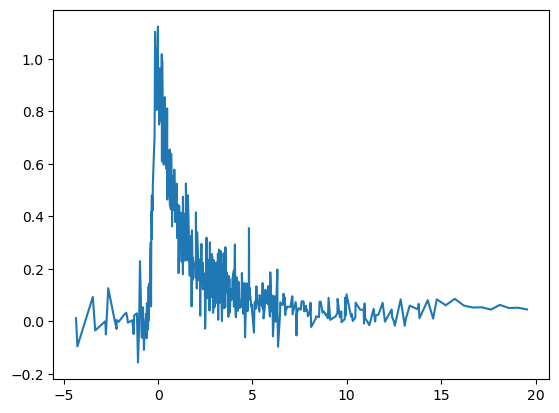

In [174]:
plt.plot(fit_time[fit_sort],fit_flux[fit_sort])

Text(0, 0.5, 'Relative Flux')

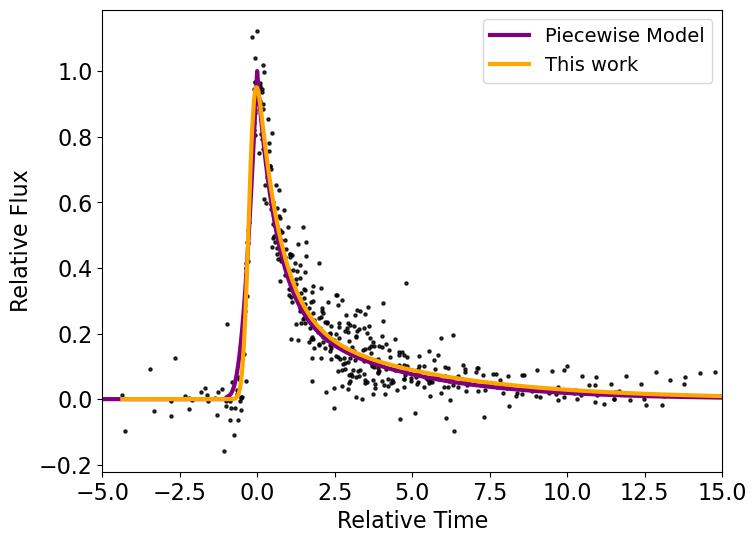

In [145]:
#shift things to be aligned at 0

plt.figure(figsize=(8, 6))
font = {'size'   : 16}
plt.rc('font', **font)
plt.plot(tess_time[tess_sort],jim_model[tess_sort],color='purple',lw=3,label='Piecewise Model')
#plt.plot(fit_time[fit_sort],jim_model[fit_sort],color='black',label='Davenport (2014) et. al')
plt.plot(fit_time[fit_sort],jackman2(fit_time,(np.median(flat_samples2,axis=0)))[fit_sort],label='This work',color='orange',lw=3)

#plt.plot(fit_time[fit_sort]-2,flare_model_v2(fit_time,(np.median(flat_samples2,axis=0)))[fit_sort],label='v2',color='red',lw=3)
#plt.plot(time[ns_all],jackman2(time,(0.91780987, 1.72326426, 0.25978216, 0.81791936, 72.63673096, 2.76862114))[ns_all],label='Jims vals',color='orange')
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=0.8,s=20,marker='.',color='black')
#plt.xlim(-4,5)
#plt.ylim(-0.2,1.3)
plt.xlim(-5,15)
plt.legend(loc='upper right',fontsize=14)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')
#plt.savefig('/Users/lupitatovar/local_flares/figures/new_stack_procedure_comparison2.pdf')

In [192]:
def flare_model_tess(t,tpeak, fwhm, ampl, upsample=False, uptime=10):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    #A,B,C,D1,D2,f1 = 2.28498875e+01,  3.66808382e+00, -3.07542717e-02,  2.26971471e-02, 8.70691332e-01,  3.52620946e-02
    A,B,C,D1,D2,f1= 3.4645243420325182, 1.7414774413655434, 0.21642749344585893, 0.22529022355253145, 1.3956510983250918,  0.21624605951503317
    #3.46452433, 1.74147744, 0.21642749, 0.22529022, 1.39565109, 0.21624606 10K steps
    #4.55800689,  3.69087082, -0.12904394,  0.01925357,  0.66034419,  0.05215795
    #previous [3.09376901,  3.74111441, -0.24209949,  0.11042946,  1.32430633,  0.17351056]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:

        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                                 + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))

    erf_bound = 0.5*(special.erf((t_new-0.2)*100) + 1)

    return flare * ampl * erf_bound


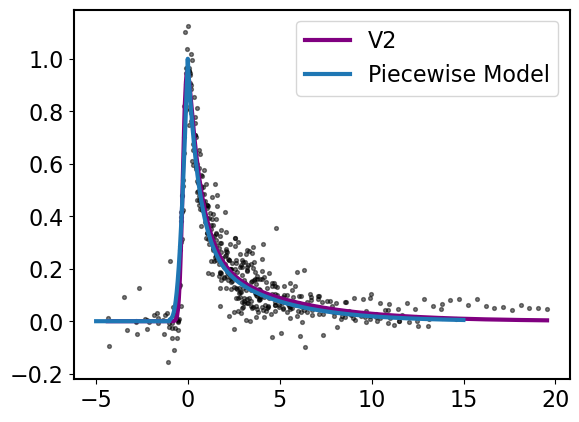

In [193]:
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=0.5,s=30,marker='.',color='black')
#plt.plot(fit_time[fit_sort]-2,jackman2(fit_time,(np.median(flat_samples2,axis=0)))[fit_sort],label='V1',color='orange',lw=3)
plt.plot(fit_time[fit_sort],flare_model_tess(fit_time,0,1,1)[fit_sort],label='V2',color='purple',lw=3)
plt.plot(tess_time[tess_sort],jim_model[tess_sort],color='C0',lw=3,label='Piecewise Model')
plt.legend()

Text(0, 0.5, 'Relative Flux')

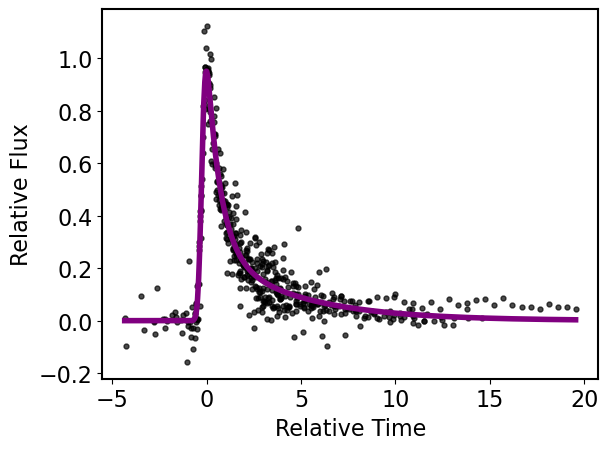

In [194]:
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=0.7,s=50,marker='.',color='black')
#plt.plot(fit_time[fit_sort]-2,jackman2(fit_time,(np.median(flat_samples2,axis=0)))[fit_sort],label='V1',color='orange',lw=3)
plt.plot(fit_time[fit_sort],flare_model_tess(fit_time,0,1,1)[fit_sort],label='V2',color='purple',lw=4)
#plt.plot(tess_time[tess_sort]+2,jim_model[tess_sort],color='C0',lw=3,label='Piecewise Model')
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.xlim(-1,10)
#plt.legend()

In [191]:
def kepler_model(t,tpeak, fwhm, ampl, upsample=False, uptime=10):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = A,B,C,D1,D2,f1 = [3.714766073353358,1.749665640328046,0.1979131664366433,0.17912992867648345,1.3591276162814818,0.19600454472080225]
    #[3.09376901,  3.74111441, -0.24209949,  0.11042946,  1.32430633,  0.17351056]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:
        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
        
    erf_bound = 0.5*(special.erf((t_new-0.2)*100) + 1)
    
    return flare * ampl * erf_bound 

(-1.0, 5.0)

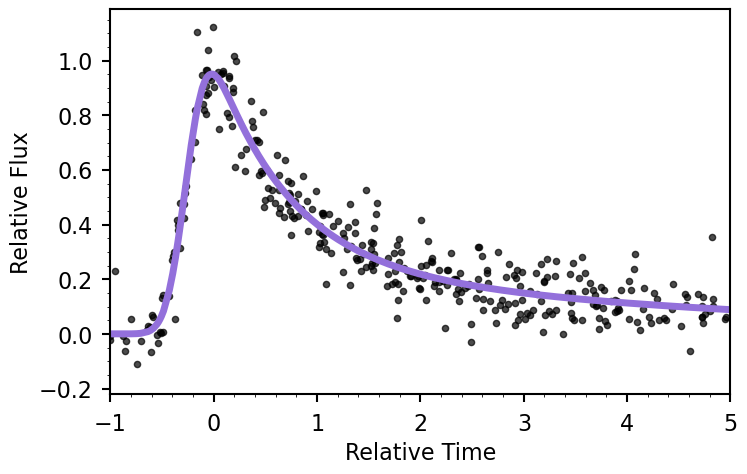

In [195]:
plt.figure(figsize=(8,5))
plt.rcParams['axes.linewidth']=1.5
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()

plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=0.7,s=80,marker='.',color='k')
#plt.plot(fit_time[fit_sort]-2,jackman2(fit_time,(np.median(flat_samples2,axis=0)))[fit_sort],label='V1',color='orange',lw=3)
#plt.plot(fit_time[fit_sort],flare_model_tess(fit_time,0,1,1)[fit_sort],label='TESS',color='mediumseagreen',lw=5)
plt.plot(fit_time[fit_sort],flare_model_tess(fit_time,0,1,1)[fit_sort],label='TESS',color='mediumpurple',lw=5)
#plt.plot(fit_time[fit_sort],kepler_model(fit_time,0,1,1)[fit_sort],label='Kepler',color='chocolate',lw=4)
#plt.plot(tess_time[tess_sort]+2,jim_model[tess_sort],color='C0',lw=3,label='Piecewise Model')
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.legend()

#colors:mediumpurple, mediumseagreen
plt.xlim(-1,5)
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_vetted_stack.png',bbox_inches='tight')

In [90]:
print(len(fit_time))
print(len(cross_match))
#print(cross_match.values[0])

503
25


(-5.0, 10.0)

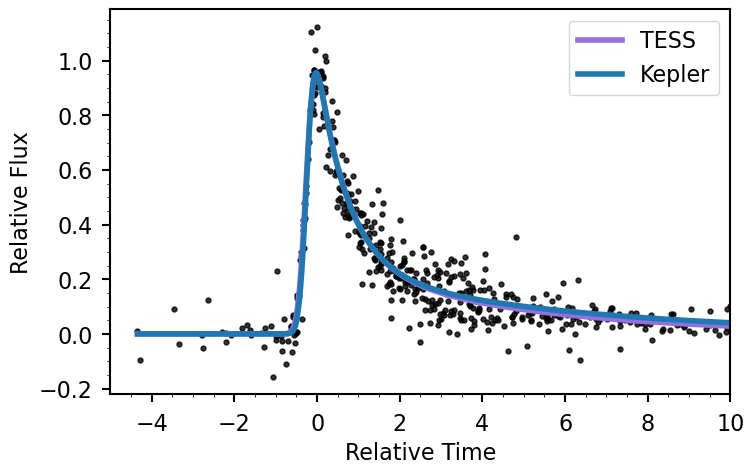

In [153]:
#overplot Kepler Model
plt.figure(figsize=(8,5))
plt.rcParams['axes.linewidth']=1.5
plt.tick_params(direction='out',width=1.5,length=6,pad=7)
plt.minorticks_on()

plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=0.8,s=50,marker='.',color='black')
#plt.plot(fit_time[fit_sort]-2,jackman2(fit_time,(np.median(flat_samples2,axis=0)))[fit_sort],label='V1',color='orange',lw=3)
plt.plot(fit_time[fit_sort],flare_model_tess(fit_time,0,1,1)[fit_sort],label='TESS',color='mediumpurple',lw=4)
plt.plot(fit_time[fit_sort],kepler_model(fit_time,0,1,1)[fit_sort],label='Kepler',color='C0',lw=4)
#plt.plot(tess_time[tess_sort]+2,jim_model[tess_sort],color='C0',lw=3,label='Piecewise Model')
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
plt.legend()
plt.xlim(-5,10)
#plt.savefig('/Users/lupitatovar/local_flares/figures/tess_kepler_comparison.png',bbox_inches='tight')

In [165]:
print(kepler_model(fit_time,0,1,1)-flare_model_tess(fit_time,0,1,1))

[-7.20425841e-03 -4.56304096e-02  6.64803698e-03 -6.02494797e-03
 -4.32922730e-03 -2.57279869e-03 -1.36912510e-03 -3.73979309e-04
  5.80168724e-04  1.56079084e-03  2.58230924e-03 -2.16322719e-04
 -1.02689449e-02 -4.60096847e-02 -2.13287431e-03 -8.50256736e-04
 -5.97707224e-03 -4.12868214e-03 -2.72750526e-03 -1.70715287e-03
 -8.68997691e-04 -9.84971743e-05  6.64767590e-04  1.44769553e-03
  2.25726331e-03  3.08935192e-03  3.93434715e-03  4.78058750e-03
  5.61639227e-03  6.43116883e-03  7.21593980e-03  7.96351148e-03
  8.66843593e-03  9.32685880e-03  9.93631649e-03  1.04955184e-02
  1.10041348e-02  1.14626044e-02  1.18719635e-02  1.22337016e-02
  1.25496391e-02  1.28218278e-02  1.30524705e-02  1.32438562e-02
  1.33983099e-02  5.74550332e-03 -3.85851317e-03 -8.20981834e-04
  1.41267639e-03  3.80815145e-03  6.22689438e-03  8.42076303e-03
  1.02425690e-02  1.16451960e-02  1.26432492e-02  1.32812083e-02
 -1.15395370e-08 -2.80074319e-02 -5.32691104e-03 -2.28668010e-03
  1.84365820e-04  2.54123

In [166]:
model_diffs = kepler_model(fit_time,0,1,1)-flare_model_tess(fit_time,0,1,1)
print(kepler_model(0,0,1,1) - flare_model_tess(0,0,1,1))
print(kepler_model(5,0,1,1) - flare_model_tess(5,0,1,1))

0.0033445212325571294
0.01196247344509066


(-0.1, 0.1)

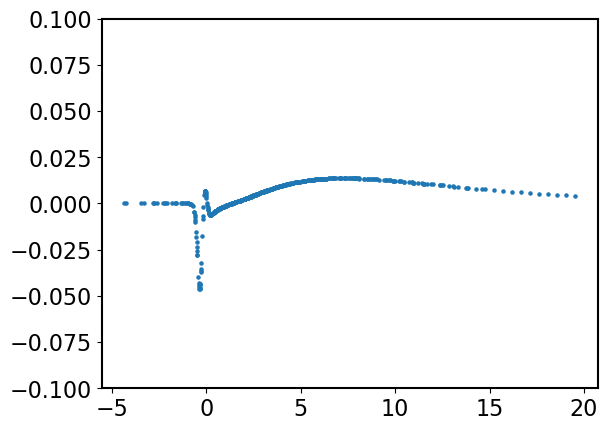

In [231]:
plt.scatter(fit_time[fit_sort],model_diffs[fit_sort],s=5)
plt.ylim(-0.1,0.1)

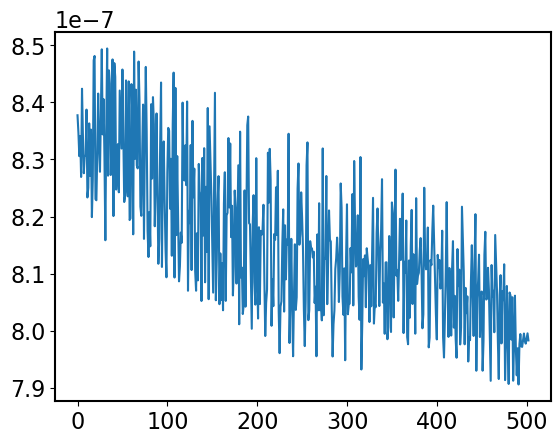

In [232]:
plt.plot(fit_both_errors[fit_sort])

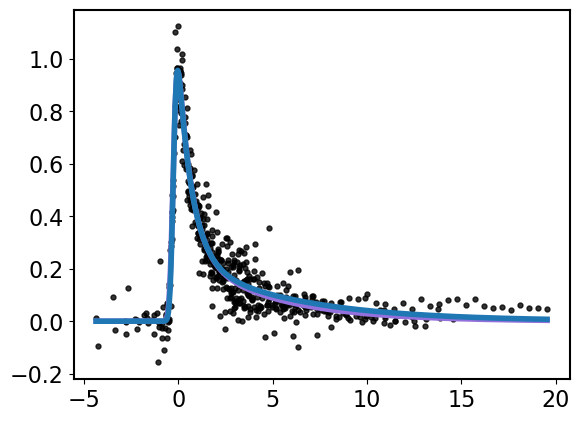

In [190]:
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=0.8,s=50,marker='.',color='black')
plt.plot(fit_time[fit_sort],flare_model_tess(fit_time,0,1,1)[fit_sort],label='TESS',color='mediumpurple',lw=4)
plt.plot(fit_time[fit_sort],kepler_model(fit_time,0,1,1)[fit_sort],label='Kepler',color='C0',lw=4)

#plt.scatter(fit_time[fit_sort],model_diffs[fit_sort],color='red')
#plt.errorbar(fit_time[fit_sort],kepler_model(fit_time,0,1,1)[fit_sort],yerr=model_diffs[fit_sort],color='red')

#plt.fill_between(fit_time[fit_sort],kepler_model(fit_time,0,1,1)[fit_sort]+flare_model_tess(fit_time,0,1,1)[fit_sort] ,kepler_model(fit_time,0,1,1)[fit_sort]-flare_model_tess(fit_time,0,1,1)[fit_sort],color='#ca6641',
                 #edgecolor="none")

Calculating a rolling median for the TESS model

Text(0, 0.5, 'Relative Flux')

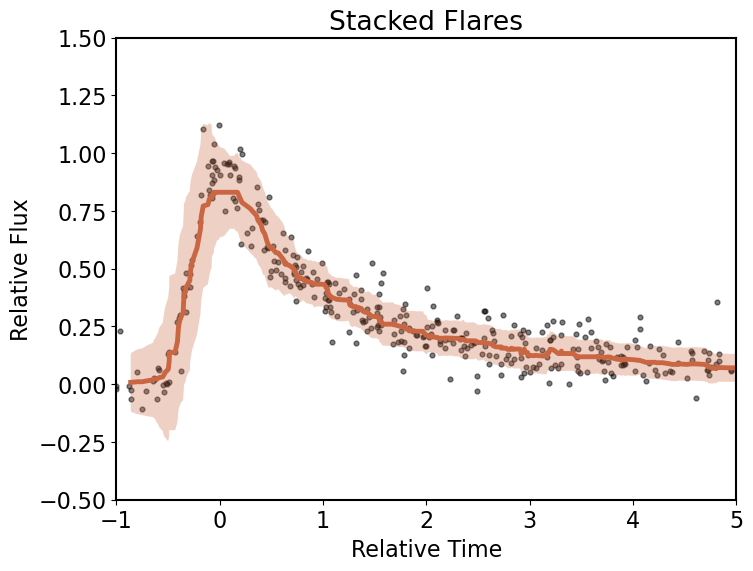

In [202]:

tess_median_fit=pd.Series(fit_flux[fit_sort]).rolling(50, center=True).median()
tess_standard_dev_fit = pd.Series(fit_flux[fit_sort]).rolling(50, center=True).std()


fig, axs = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k')


axs.scatter(fit_time[fit_sort],fit_flux[fit_sort],color='k',alpha=0.5,s=12)



axs.plot(fit_time[fit_sort],tess_median_fit,color='#ca6641',lw=3.5)

axs.fill_between(fit_time[fit_sort], tess_median_fit+tess_standard_dev_fit, tess_median_fit-tess_standard_dev_fit,color='#ca6641', alpha=0.3,
                 edgecolor="none")




    #Axes limits
axs.set_xlim(-1,5)
axs.set_ylim(-0.5,1.5) 



    #Setting Titles
axs.set_title('Stacked Flares')

    

    #Axes labels
axs.set_xlabel("Relative Time",fontsize=16)
axs.set_ylabel("Relative Flux",fontsize=16)    


    #Legend
    #ax1.legend(loc='lower right')


In [215]:
xmin = -1
xmax= 5
ymin = -0.5
ymax= 1.5
both_mask = np.where((fit_time[fit_sort] > xmin) & (fit_time[fit_sort] < xmax) & (fit_flux[fit_sort] > ymin) & (fit_flux[fit_sort] < ymax))[0]

chi2_tess_med = np.sum(((fit_flux[fit_sort][both_mask]- tess_median_fit[both_mask])/fit_both_errors[fit_sort][both_mask])**2)/(len(both_mask))
print('Chi Squared of rolling median of final vet fit flares:' +str(chi2_tess_med))   

Chi Squared of rolling median of final vet fit flares:10419995945.688362


Text(0, 0.5, 'Relative Flux')

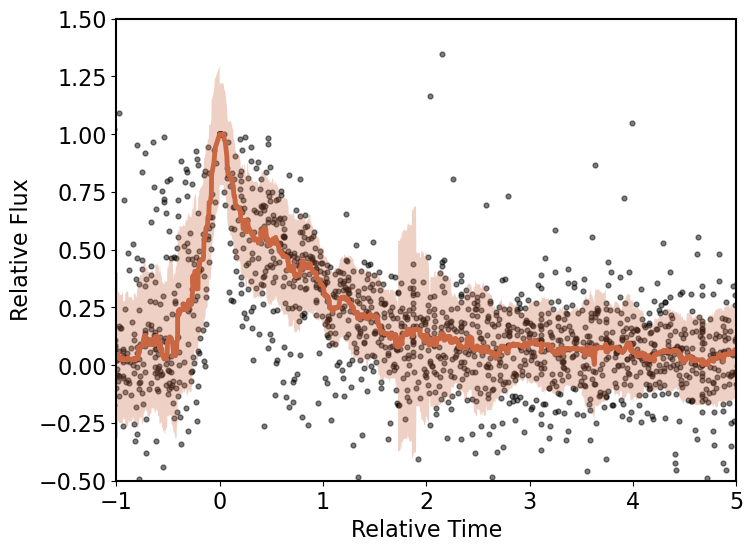

In [235]:

tess_median_classic=pd.Series(flux_classical[classic_sort]).rolling(51, center=True).median()
tess_standard_dev_classic = pd.Series(flux_classical[classic_sort]).rolling(51, center=True).std()


fig, axs = plt.subplots(1,1, figsize=(8,6), facecolor='w', edgecolor='k')


axs.scatter(time_classical[classic_sort],flux_classical[classic_sort],color='k',alpha=0.5,s=12)



axs.plot(time_classical[classic_sort],tess_median_classic,color='#ca6641',lw=3.5)

axs.fill_between(time_classical[classic_sort], tess_median_classic+tess_standard_dev_classic, tess_median_classic-tess_standard_dev_classic,color='#ca6641', alpha=0.3,
                 edgecolor="none")




    #Axes limits
axs.set_xlim(-1,5)
axs.set_ylim(-0.5,1.5) 



    #Setting Titles
#axs.set_title('Stacked Flares')

    

    #Axes labels
axs.set_xlabel("Relative Time",fontsize=16)
axs.set_ylabel("Relative Flux",fontsize=16)    


    #Legend
    #ax1.legend(loc='lower right')


In [218]:
mask2 = np.where((time_classical[classic_sort] > xmin) & (time_classical[classic_sort] < xmax) & (flux_classical[classic_sort] > ymin) & (flux_classical[classic_sort] < ymax))[0]

chi2 = np.sum(((flux_classical[classic_sort][mask2]- tess_median_classic[mask2])/both_errors_classical[classic_sort][mask2])**2)/(len(mask2))
print('Chi Squared of rolling median of classical set of flares:' +str(chi2))   

Chi Squared of rolling median of classical set of flares:4.597010296913442


Showing the scatter in the model (i.e subtracting median from model)

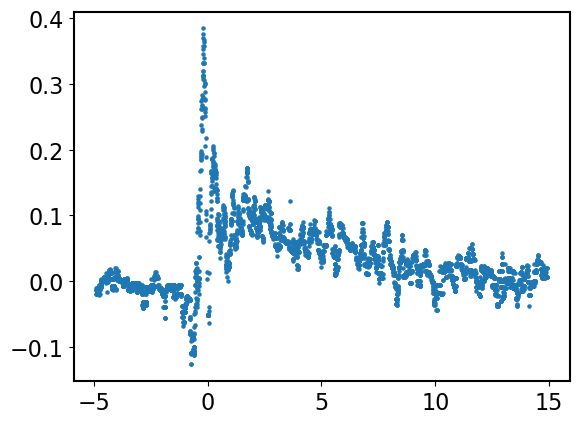

In [236]:
residual = flare_model_tess(time_classical,0,1,1)[classic_sort]-tess_median_classic
residual_fit = flare_model_tess(fit_flux,0,1,1)[fit_sort]-tess_median_fit
plt.scatter(time_classical[classic_sort],residual,s=5)
#plt.scatter(fit_time[fit_sort],residual_fit,color='orange')